

This notebook will review aspects of encounters in Dragon Quest III related to encounter formation probabilities. The goal of the analysis is primarily to best understand the distribution of encounters in areas related to the standard RTA (real time attack) route, with some additional areas out of curiousity. 

### Encounter mechanics

First, we'll discuss a few things about encounters to set the context for the data & analysis:
* Encounters are triggered when a threshold (2-byte RAM address 0x00F796) reaches 0. 
  * Depletion occurs while walking in areas with encounters (dungeons & overworld primarily), by which a starting value is set upon a number of actions. In simplest terms, a value is set, the player walks around, depleting that value to zero, then a battle occurs. Encounters are not frame-based to trigger.
  * Encounter starting values are set by actions such as triggering a battle (thereby setting the next starting value), entering a new area/screen transition, or using the lamp of darkness (common RTA strategy). 
* While encounters are not frame-based to trigger, the formations are frame-based. Every frame will yield a different encounter depending on the area. 
  * The world map (both light & dark world) in DQIII are aligned in a tile grid format, where encounters will adhere to the grid for all possible formations for that given tile. For dungeons, simply the entire floor adheres to the same set of formations, and may overlap with others in the same dungeon. The below images/data will illustrate where the encounters take place. Generically, these areas referred to as the 'encounter zone'. 
* Overworld encounters do not vary by tile in which they are triggered, and only adhere to the encounter zone grid system. That is, there is no uneven distribution for encounter based on if the tile is a forest, mountain, plains, swamp, etc. 
* Dungeons have varying amounts of encounter areas with set formations. For example, Najimi Tower's first two floors are the same encounter zone, then change. Many dungeons are like this. 
* As evidenced by the data below, there appears to be two main ways encounters draw:
  * Case 1 - Encounters take place in pre-set formations per area, and do not deviate (for example, 1x SkyDragon 7x Metaly in Garuna Tower)
  * Case 2 - Encounters are dynamically generated by taking certain enemies (but not all!) in an encounter zone and populating the fight, limited by the space available on the battle screen. (for example, 2x Garuda 2x VenomMoth 1x Metaly, or 3x VenomMoth 3x Metaly, etc.) 
  * What's interesting is that the probabilities and distribution of overall Case 1 vs. Case 2 change drastically per encounter zone, evident in the data views below. 
    * Further, some monsters and formations will never appear between Case 1 and 2. For example, near Samanosa Shrine, the player can fight 1 Liquid Metal Slime (Case 1) that only shows up alone. There are many Case 2 encounters with other enemies, but Liquid Metal Slime will *never* appear with the other enemies in a Case 2 encounter. If nothing else, this activity alone gives credence to this analysis, which is to understand and assess all *actual* encounters per encounter zone, and not based on some extended analysis. 

### Data retrieval methodology

There exist a handful of resources on encounters in DQIII, but none about their probability of occurring. The methodology was quite simple - after confirming the above points regarding how encounters draw, brute-force log encounters. 

A lua script was developed to log these encounters. For every area logged, which includes the unique intersection of map type, encounter zone, and time of day, the script logged 10,000 encounters. For example, right outside Aliahan after starting the game would be map type "Overworld", encounter zone "Aliahan", time of day "Day". 

In sum, a total of 144 areas were logged. The script took about 140 minutes per area, which was using Bizhawk version 2.2 at unthrottled speed, and ranged between 180-240fps. 3 computers were set up to run these scripts. Combined run time would calculate to roughly 336 hours of mostly non-manual script running. 
* One may question the significance of the threshold of using 10k encounters. This will be discussed below in an appendix example, but essentially one area was checked with 60k encounters with 6 different sub-data sets generated (at 10k each), then these were compared against each other. All 6 had less than .1% variance to eachother for formation probabilities, which lead to confidence in the 10k threshold.

Finally, there was no attempt to pull apart the assembly code to back in to encounter methodology based on some internal game-code methodology. Given some of the strangeness in probabilities with specific case 1/2 formations (discussed above), estimating based on the game code would both be incredibly cumbersome to unearth, and potentially unaccurate unless the code was 100% translated correctly. From the organizer's standpoint, logging encounters based on what happens in a live RTA setting is most important, and is thus simulated at length here.

### Results

Every unique encounter zone, map type and time (day/night) combination will be detailed below. When applicable for areas that have day/night (only light world, overworld), the results will be shown next to each other (which further valides the views, as most areas have very similar (or the exact same) day/night distributions). The results will be shown by overworld (land), overworld (sea), then dungeons. Some additional commentary will be given in special areas, such as when metals (Metal Slime & Liquid Metal Slime) appear, and what the overall probability of encountering one is. 

This primarily will serve as an informative resource to those who RTA this game. There is no modeling or speculative purpose of this analysis- it is simply designed to best understand the probabilities behind encounters, when they occur. Much is already understood about how the game sets encounter thresholds and techniques used to reduce encounters (such as resetting an area, using Tiptoe/Shinobi Feet, or forcing an encounter in a less-threatening area). The goal here is to understand more about encounters themselves. 

Again, this notebook is designed to primarily follow encounters that occur within the RTA. This notebook will be updated based on further findings/requests for specific areas.

There exist many resources out there for DQIII information, some of which may have captured some of this before. However, for this information regarding encounter distribution, the organizer felt that verifiability of the processes used for information found elsewhere was weak or unspoken, and a full, clean analysis was worthwhile. 

Finally, for those unfamiliar, results herein are displayed via Python code, which access the underlying data file and pull the stats/graphs for each specific area. 

Thanks for reading! Any questions or observations, contact me at:
* @cleartonic
* twitch.tv/cleartonic
* discord.gg/cleartonic

Or on the Dragon Quest RTA Discord:
* discord.gg/HvZHycp

In [109]:
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns


In [110]:
df_master = pd.read_csv('Lua/dumps/dq3/master/dq3-encounter_analytic.csv', dtype={"index": int, "Map Type": str, "Area Code": int, "Zone": str, "Time": str, "Formation": str, "Formation_j": str})


In [117]:
%%capture
## TEMP FOR TESTING OVERWORLD
df = df_master.copy()
#df = df_master.loc[(df_master['Map Type'] == "Dungeon")]
##

maptypes_list = df['Map Type'].unique().tolist()

In [118]:
daynightlist = ['Samanosa (2)','Baharata (3)','Silver Orb Shrine','Kazave','Lamia Shrine','Samanosa (1)','Romaly','Samanosa (4)','Desert','Dhama (1)','Reeve','To Kandar 2','Edinbear','Isis','Tedanki','Baharata (1)','Dhama (2)','Merchant Town','Aliahan','Necrogond','Portoga','Baharata (2)','To Samanosa Shrine','To Magic Ball','Samanosa (3)','To Assalam']

In [119]:
def return_daynight(df_first, maptype, zone):
    df_list = []
    for daynight in ['Day','Night']:
        df_temp = df_first.loc[(df['Map Type'] == maptype) & (df_first['Zone'] == zone) & (df_first['Time'] == daynight)]
        df_query = pd.DataFrame(df_temp['Formation'].value_counts())
        df_query_j = pd.DataFrame(df_temp['Formation_j'].value_counts())
        df_query = df_query.reset_index()
        df_query_j = df_query_j.reset_index()
        df_query_both = pd.concat([df_query, df_query_j], axis=1)
        df_query_both.columns = ['Formation', 'Count', 'Formation_j', 'Count 2']
        df_query_both = df_query_both[['Formation','Formation_j','Count']]
        df_query_both['%'] = df_query_both['Count']/df_query_both['Count'].sum()
        df_query_both = df_query_both[0:10]
        df_list.append(df_query_both)
    return df_list

def return_df(df_temp, maptype, zone):
    df_temp = df_temp.loc[(df_temp['Map Type'] == maptype) & (df_temp['Zone'] == zone)]
    df_query = pd.DataFrame(df_temp['Formation'].value_counts())
    df_query_j = pd.DataFrame(df_temp['Formation_j'].value_counts())
    df_query = df_query.reset_index()
    df_query_j = df_query_j.reset_index()
    df_query_both = pd.concat([df_query, df_query_j], axis=1)
    df_query_both.columns = ['Formation', 'Count', 'Formation_j', 'Count 2']
    df_query_both = df_query_both[['Formation','Formation_j','Count']]
    df_query_both['%'] = df_query_both['Count']/df_query_both['Count'].sum()
    df_query_both = df_query_both[0:10]
    return df_query_both

In [120]:
#plot.set_xticklabels(plot.get_xticklabels(), rotation=-45, ha='left')

def plot_two(df_day, df_night, maptype, zone):
    sns.set_style('ticks')
    sns.set_context(font_scale=1.4)
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    fig.set_size_inches(16, 6)
    sns.barplot(x=df_day['Formation'],y=df_day['%'],ax=ax1).set_title('Day')
    sns.barplot(x=df_night['Formation'],y=df_night['%'],ax=ax2).set_title('Night')
    for ax in fig.axes:
        matplotlib.pyplot.sca(ax)
        plt.xticks(rotation=45, ha='right')
    plt.subplots_adjust(top=.8)
    fig.suptitle(maptype+" - "+zone)
    plt.show()
    
def plot_one(df_query, maptype, zone):
    sns.set_style('ticks')
    sns.set_context(font_scale=1.4)
    fig, ax = plt.subplots(ncols=1)
    fig.set_size_inches(16, 6)
    sns.barplot(x=df_query['Formation'],y=df_query['%'])
    for ax in fig.axes:
        matplotlib.pyplot.sca(ax)
        plt.xticks(rotation=45, ha='right')
    plt.subplots_adjust(top=.8)
    fig.suptitle(maptype+" - "+zone)
    plt.show()

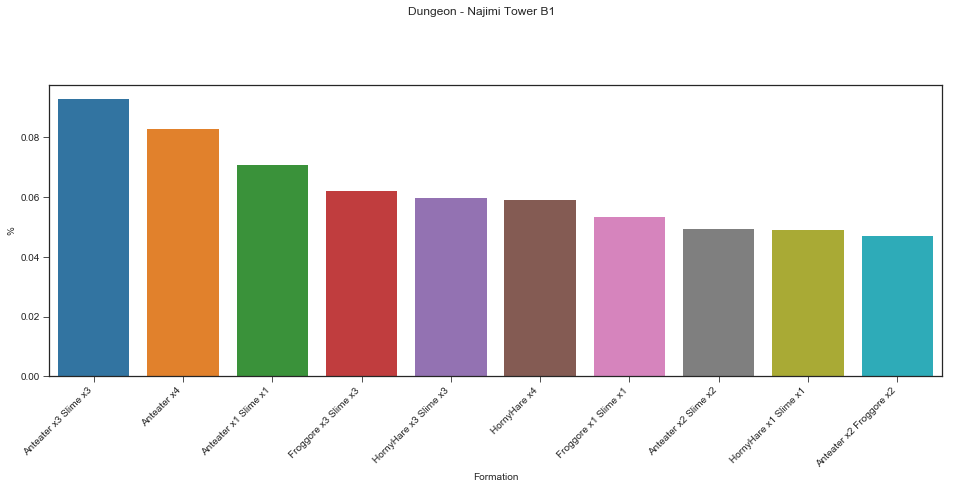

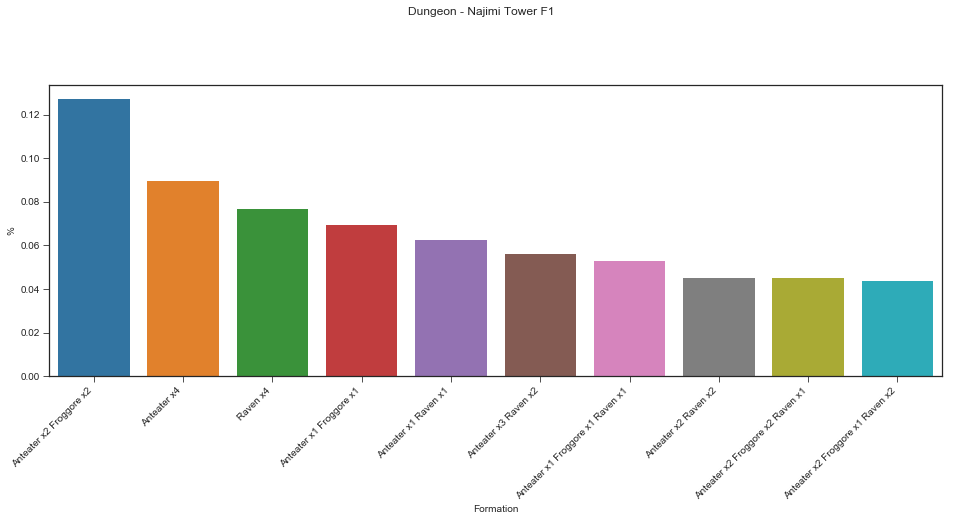

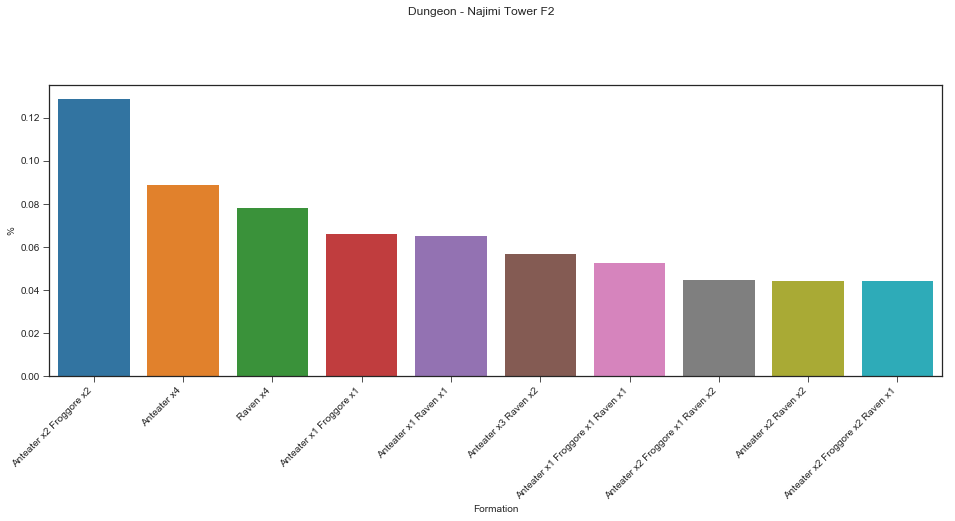

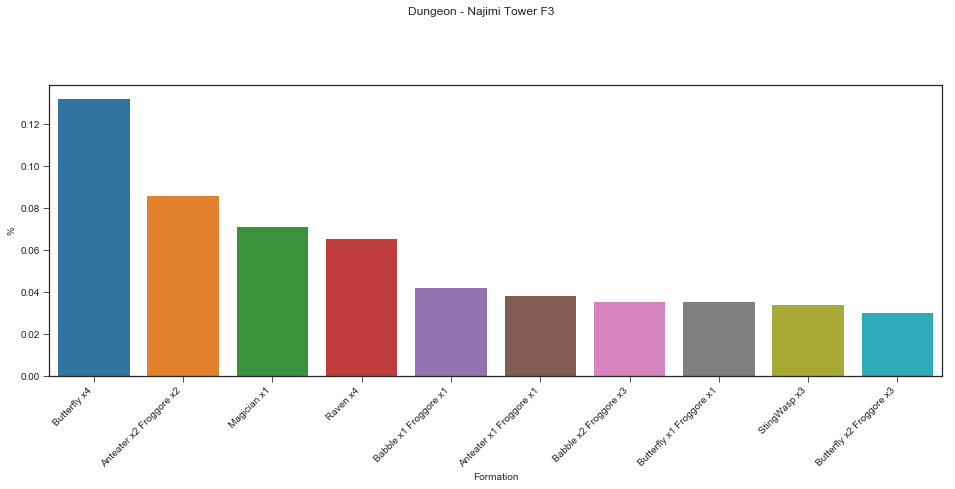

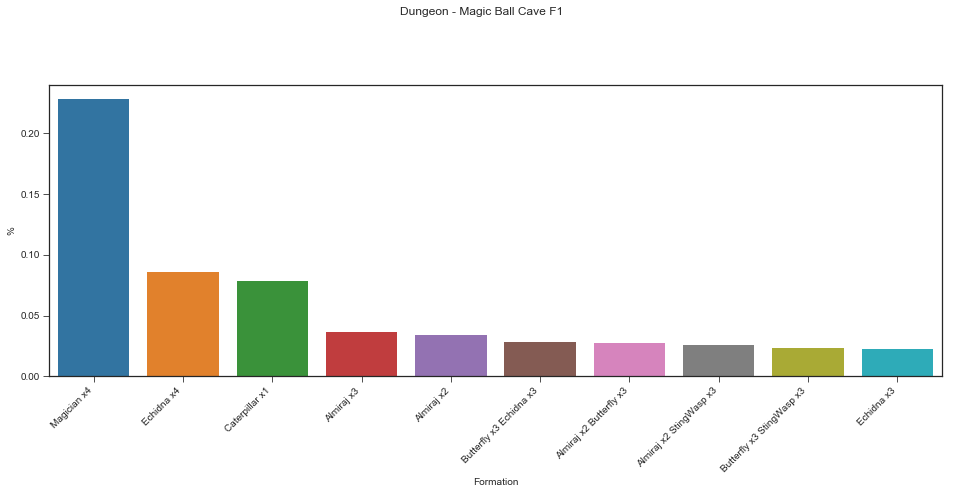

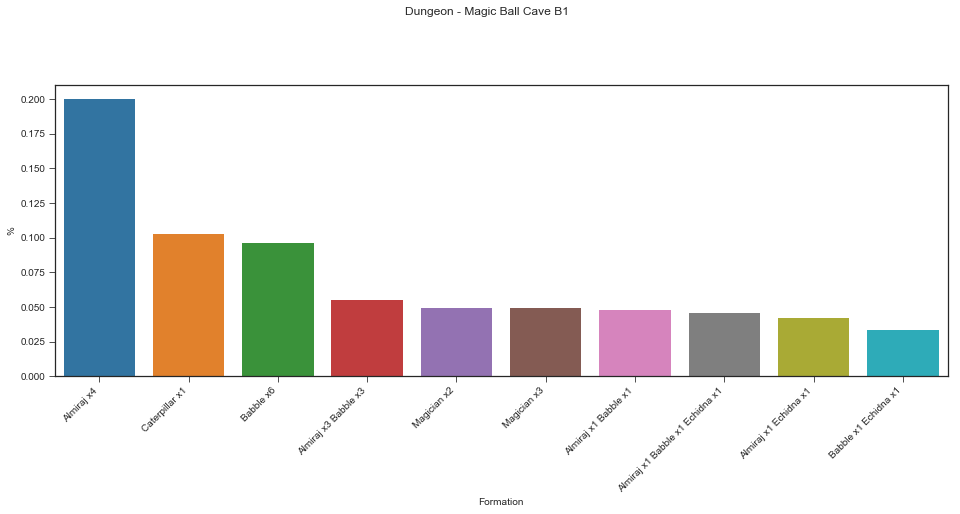

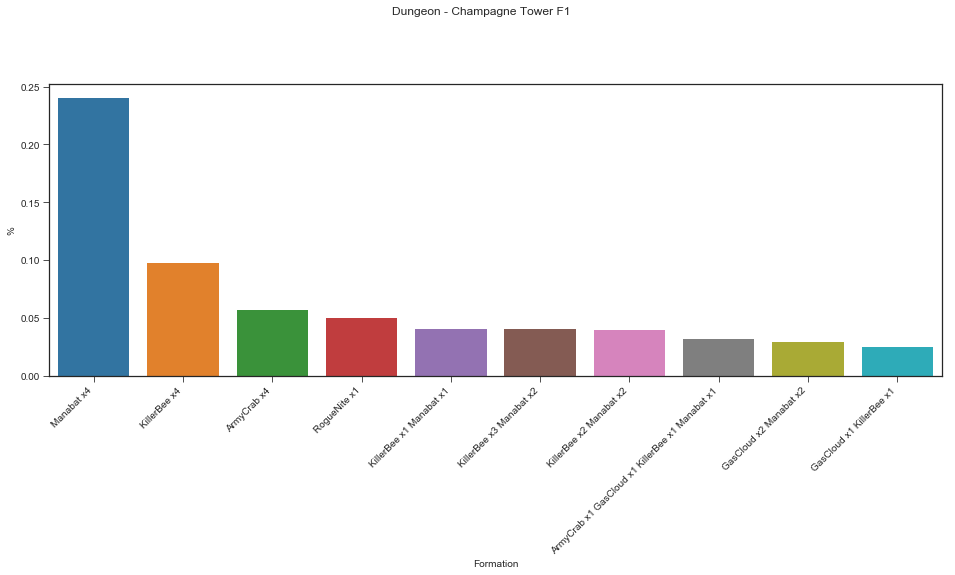

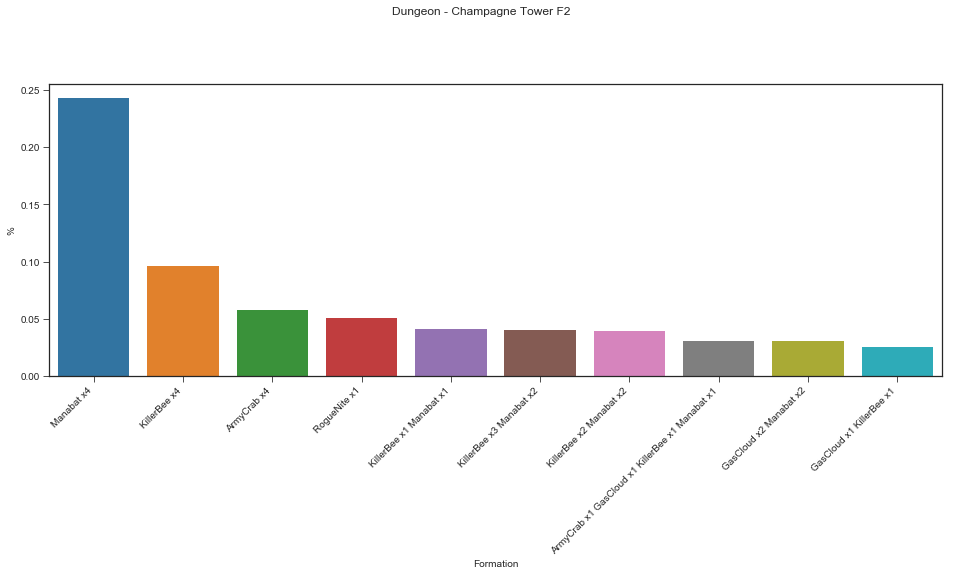

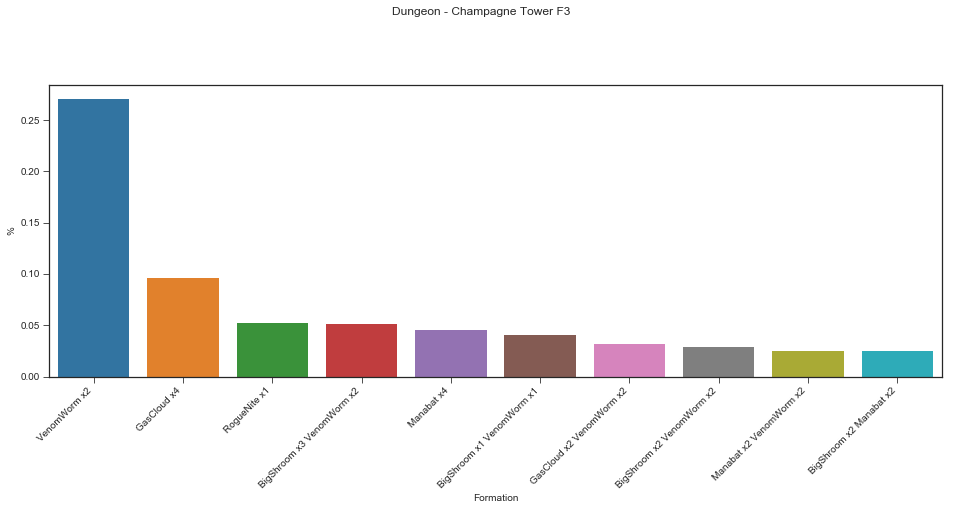

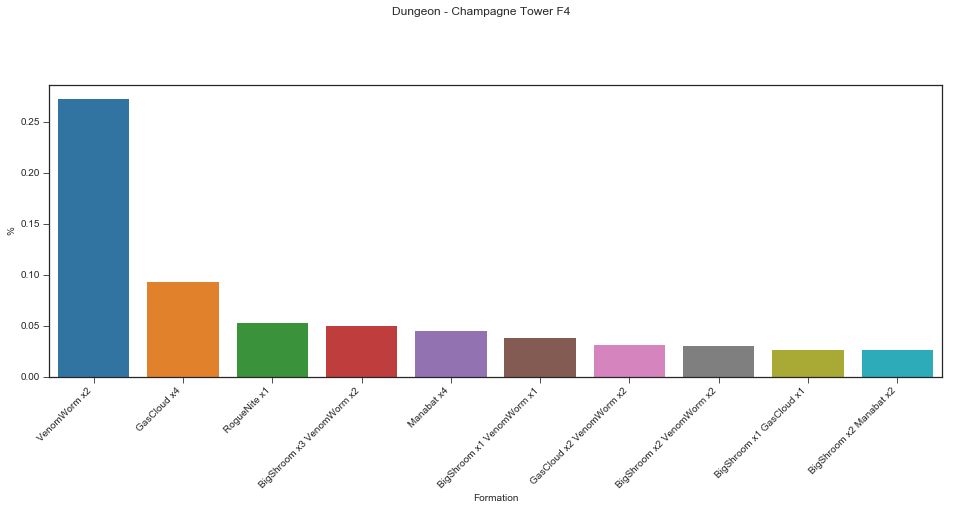

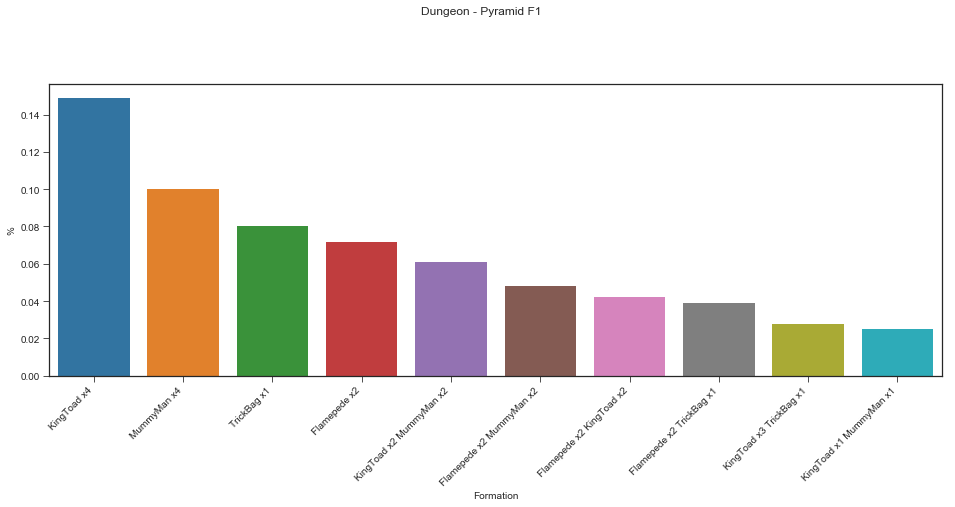

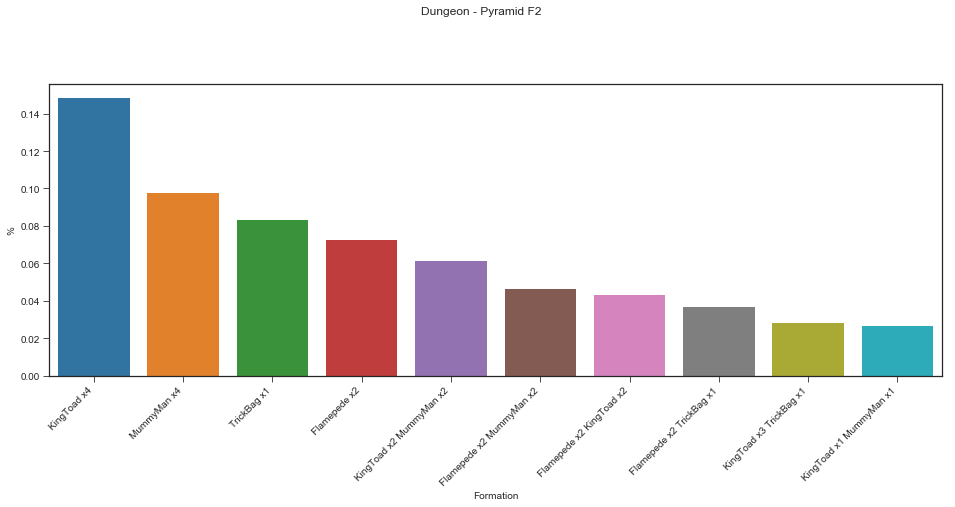

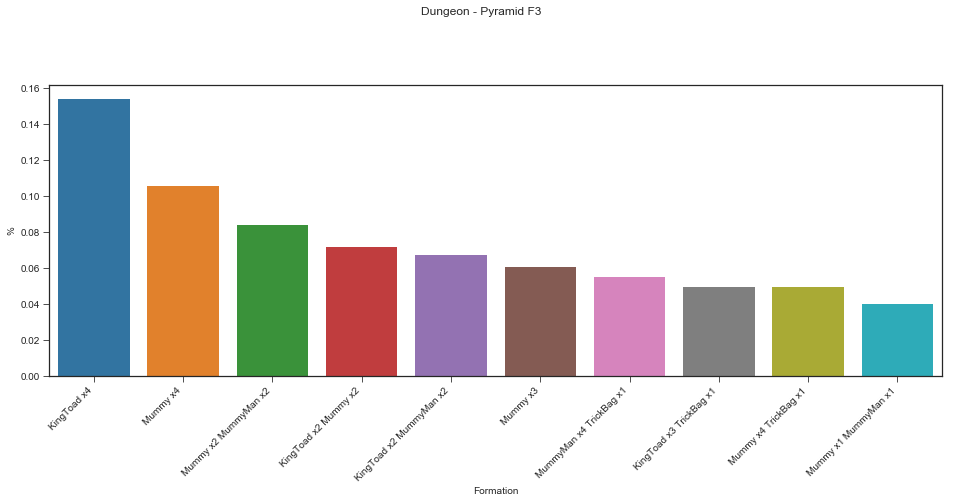

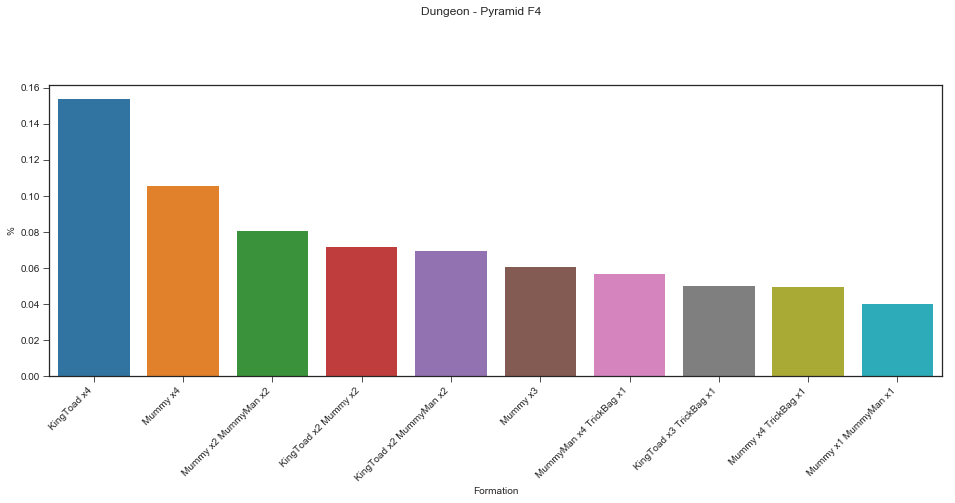

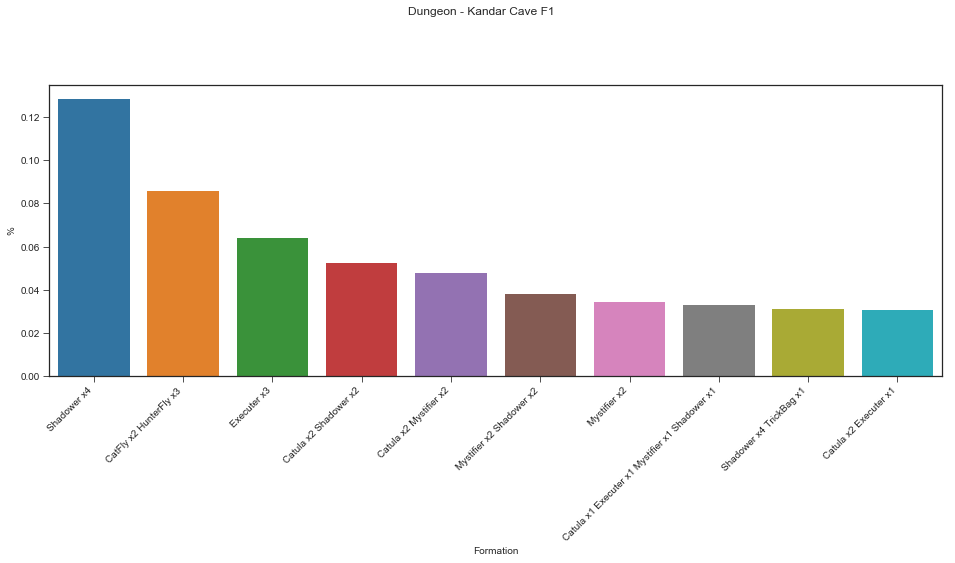

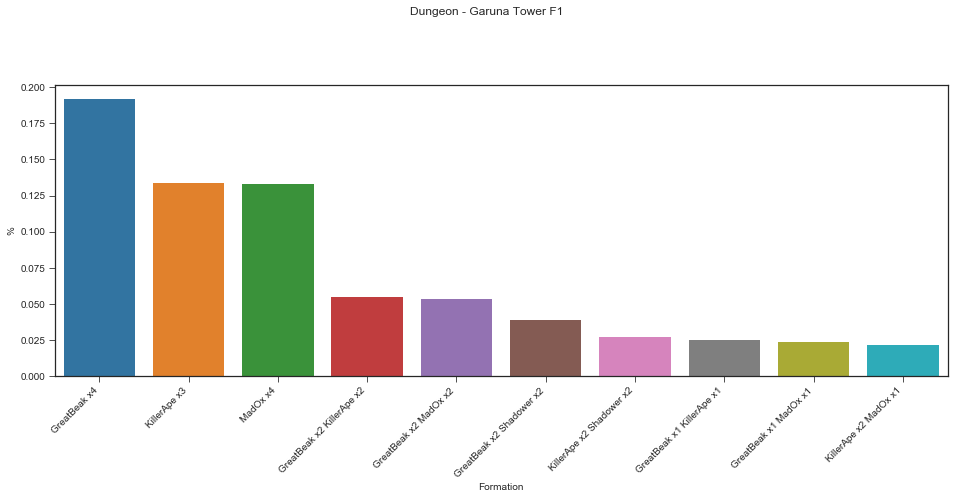

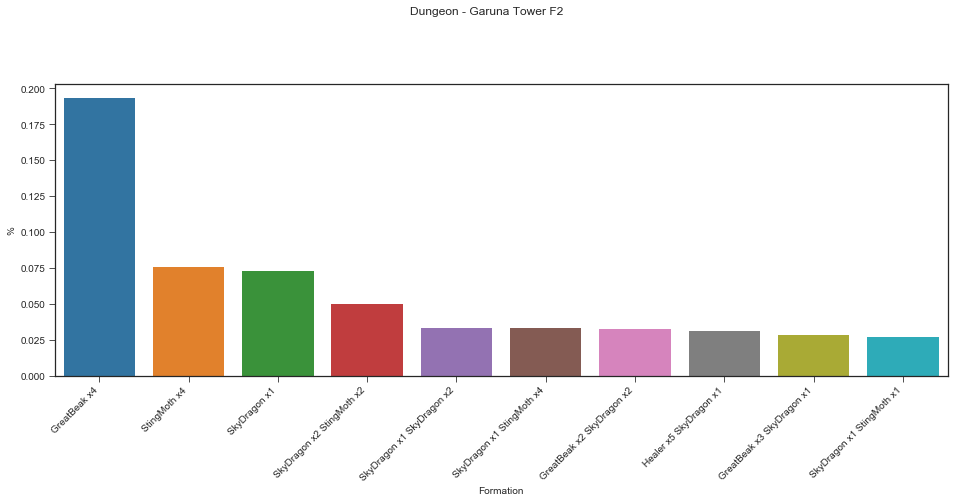

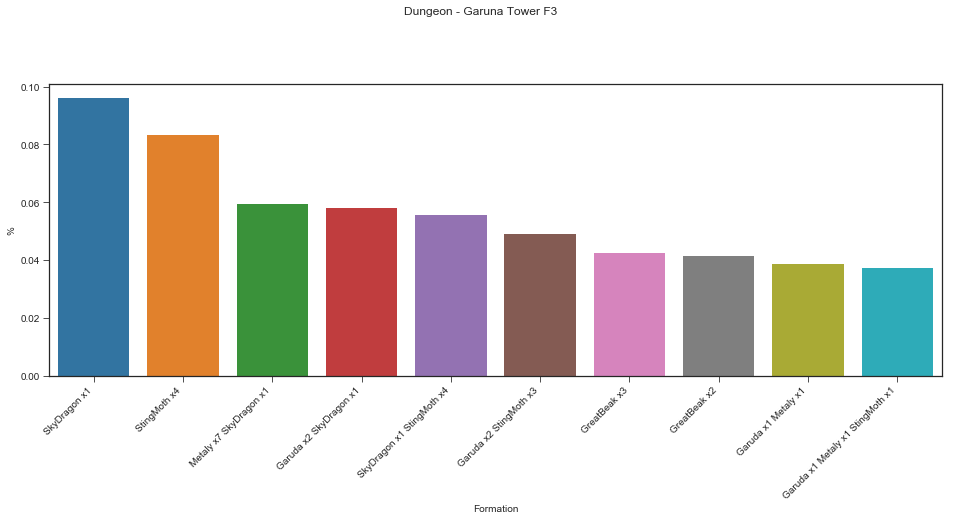

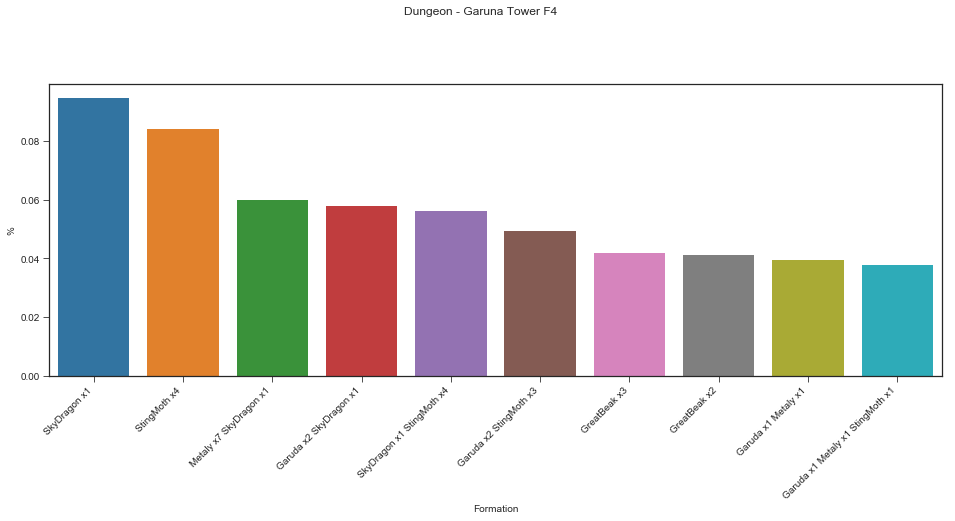

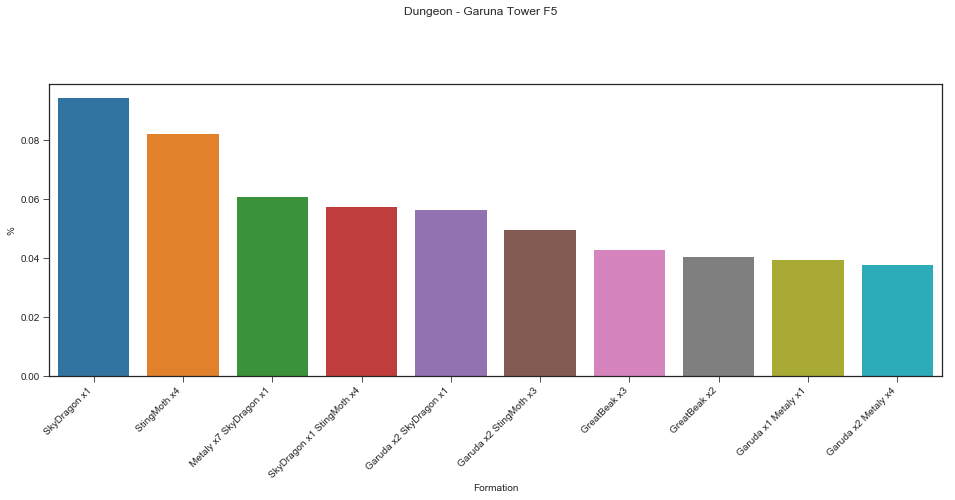

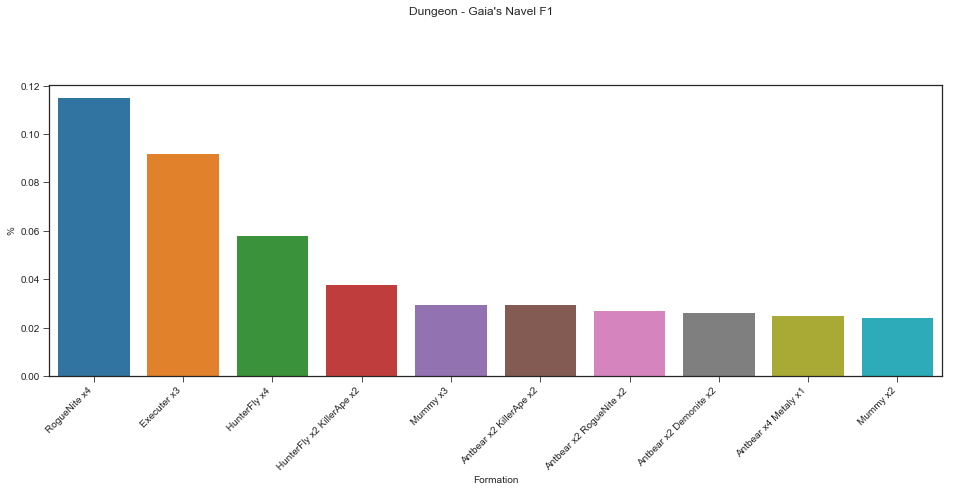

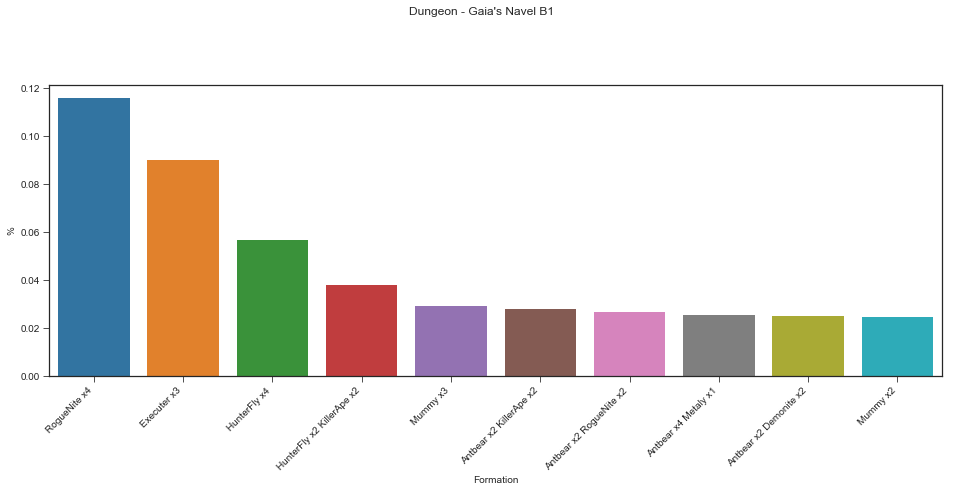

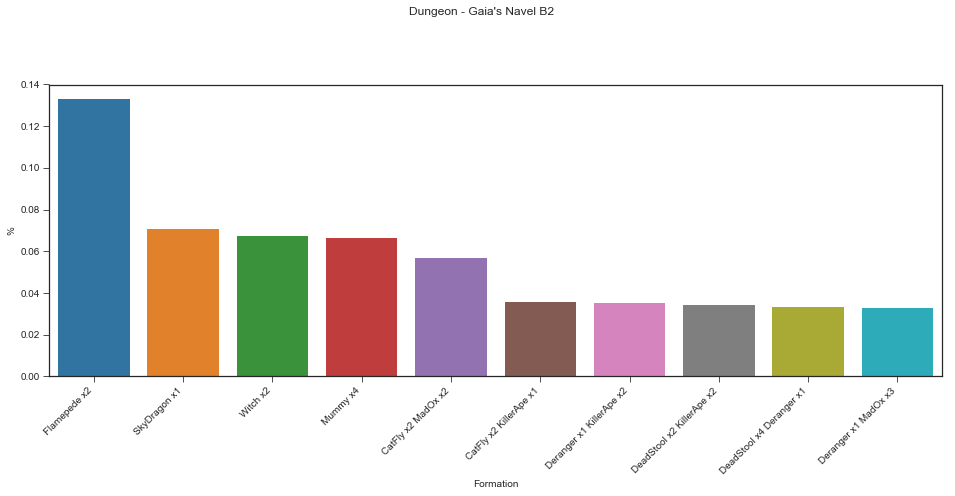

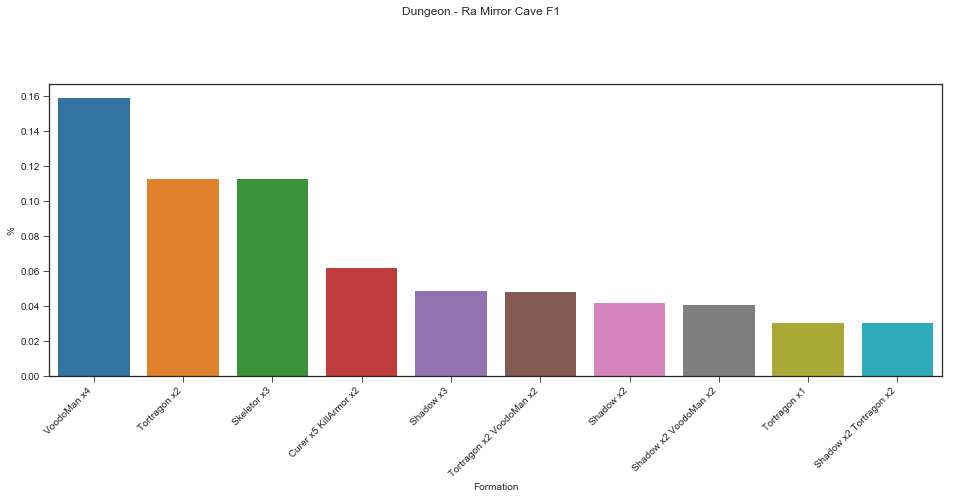

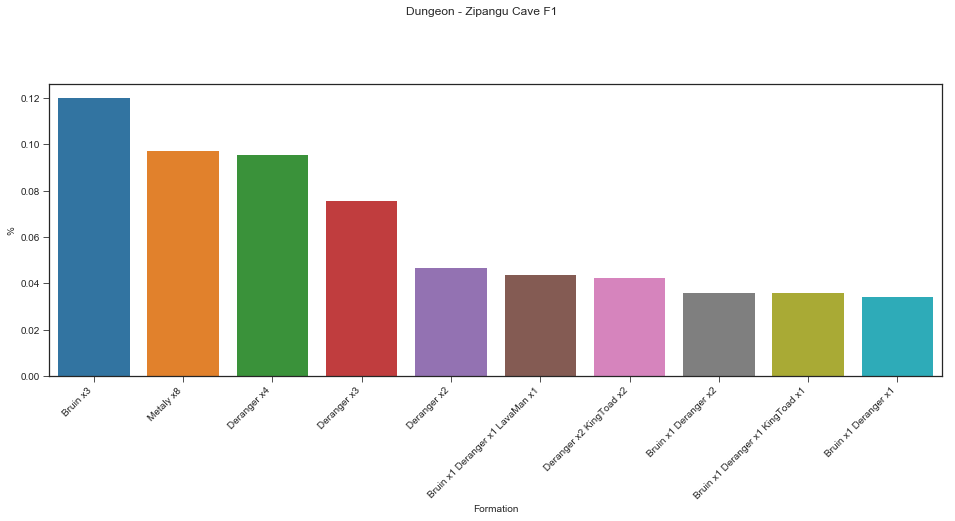

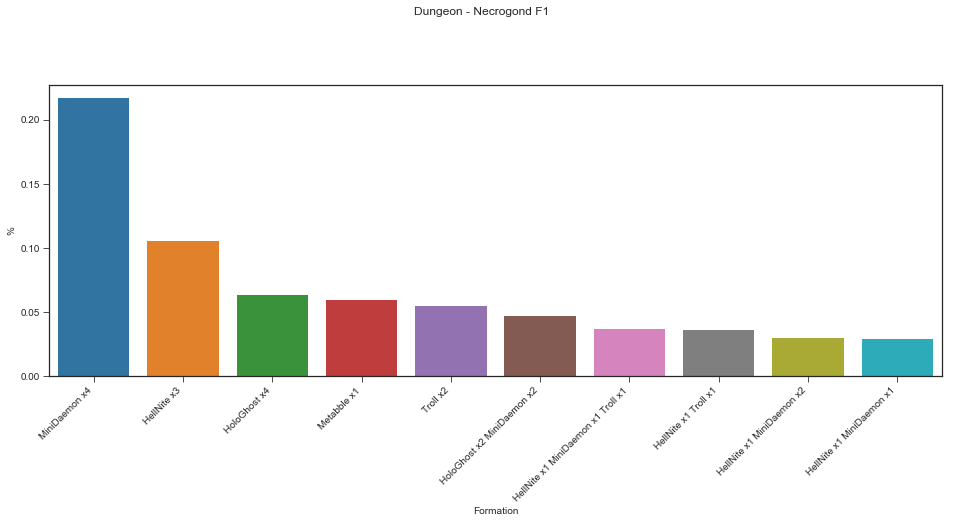

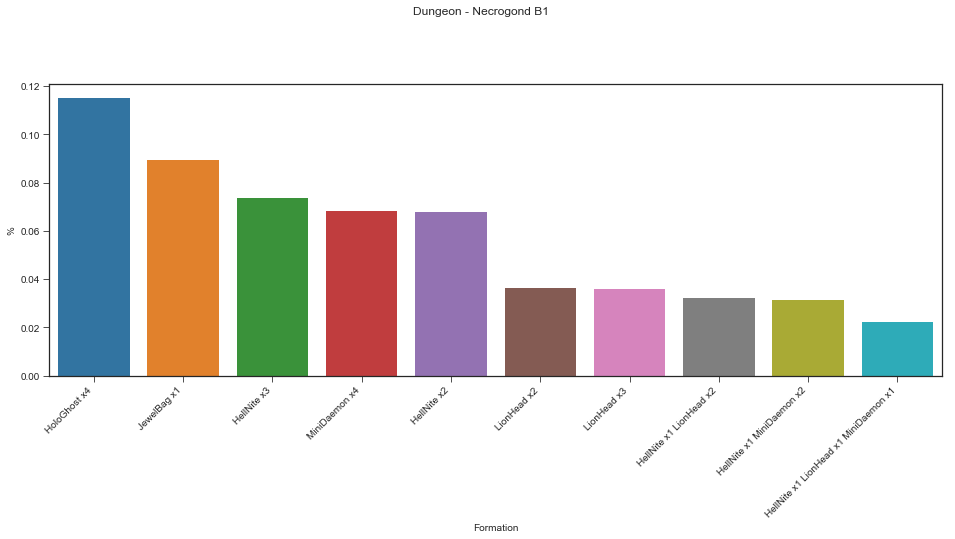

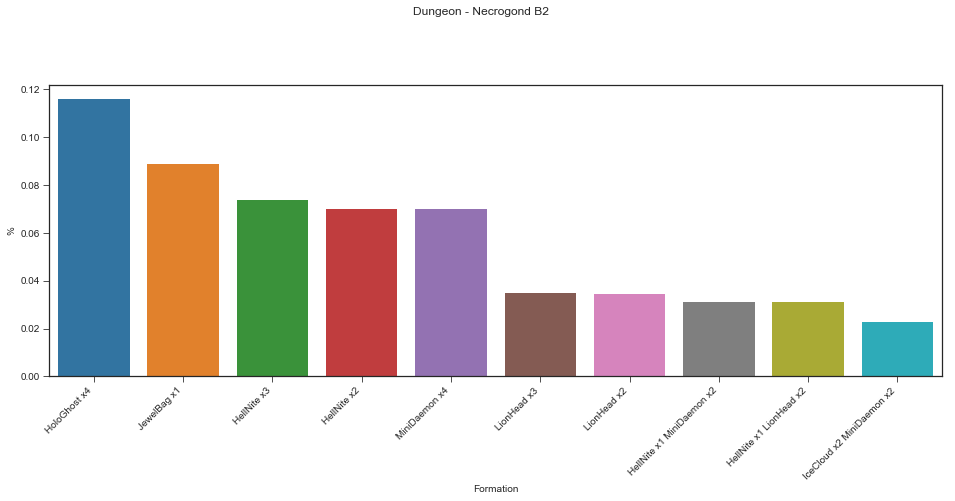

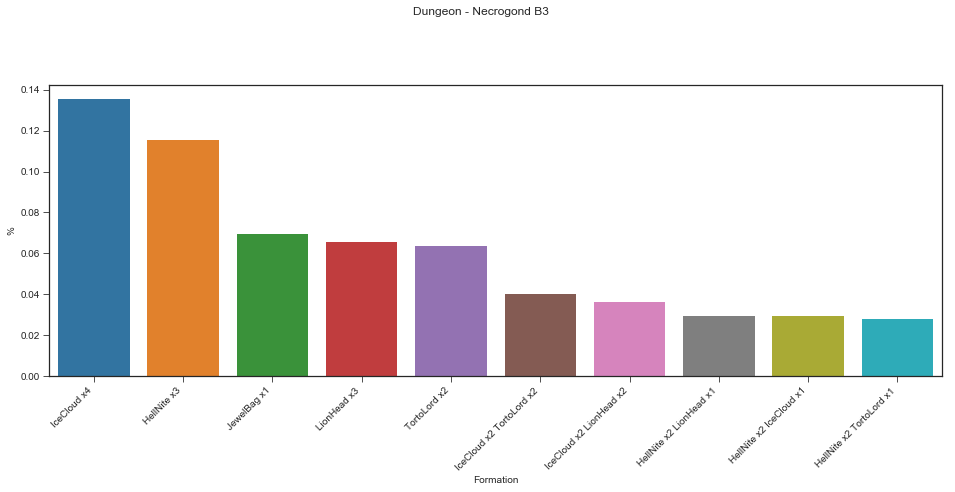

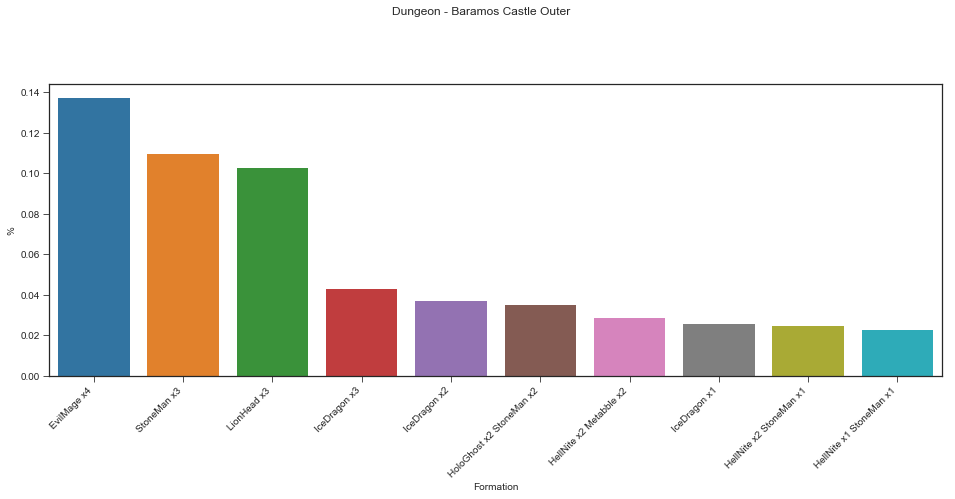

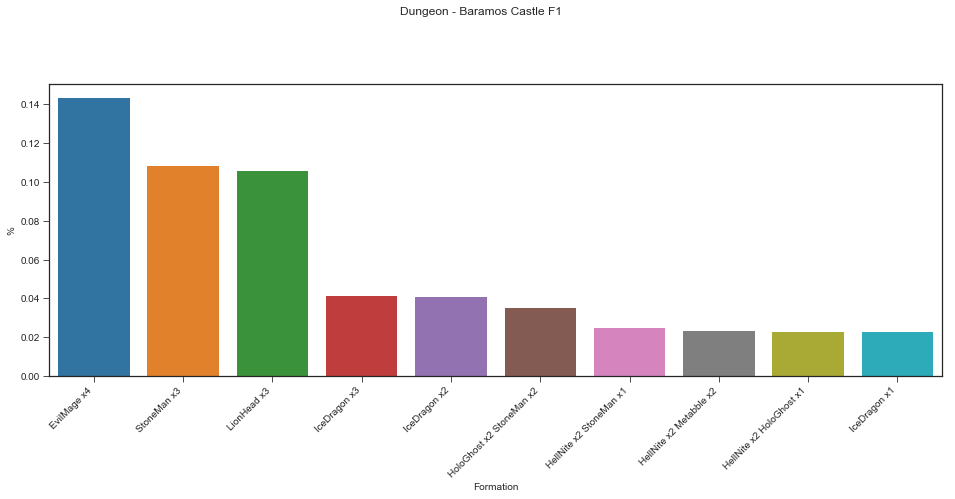

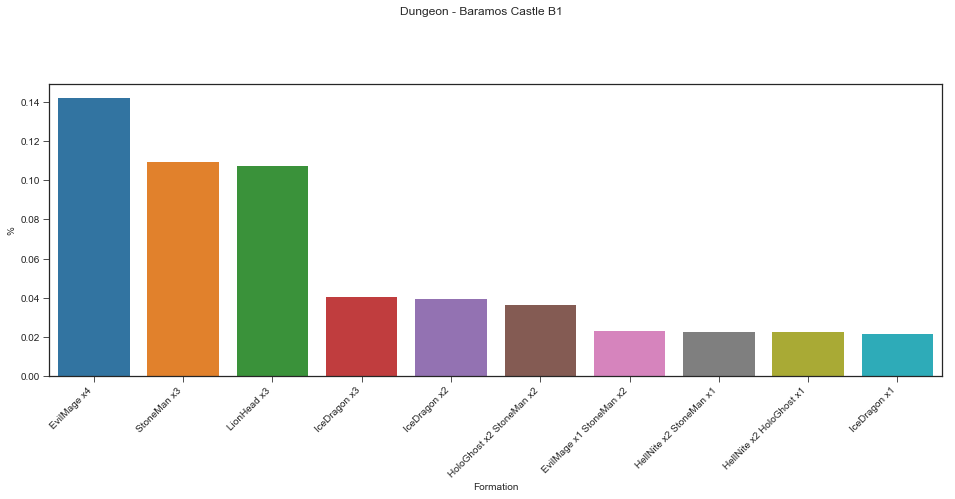

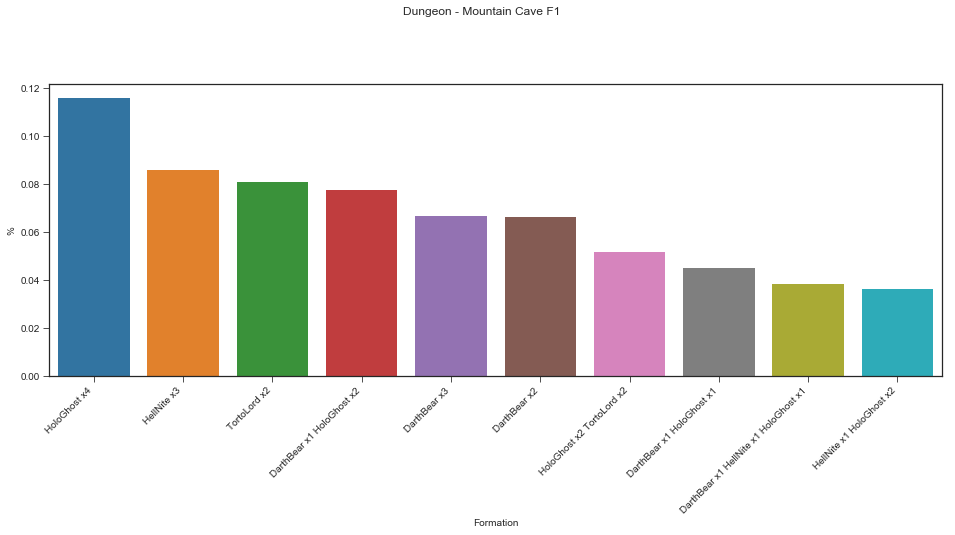

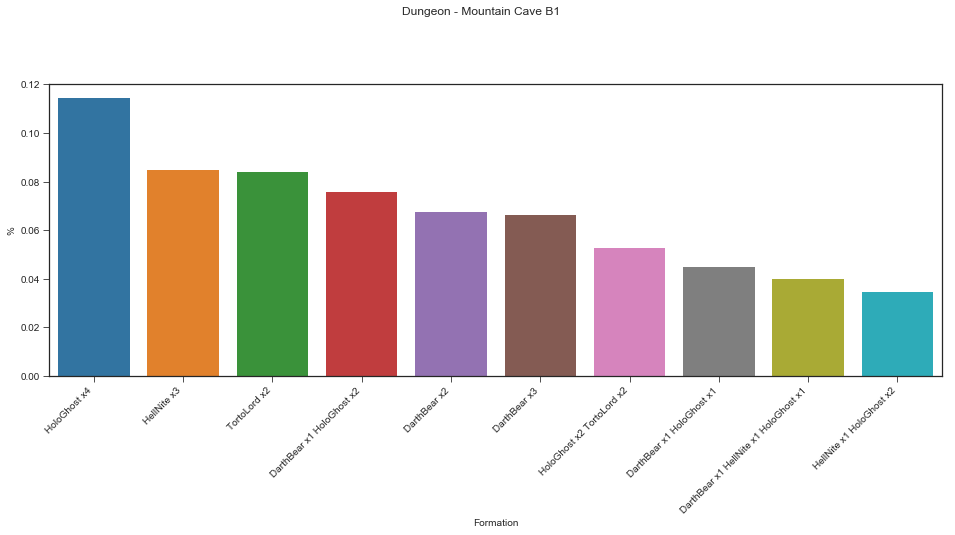

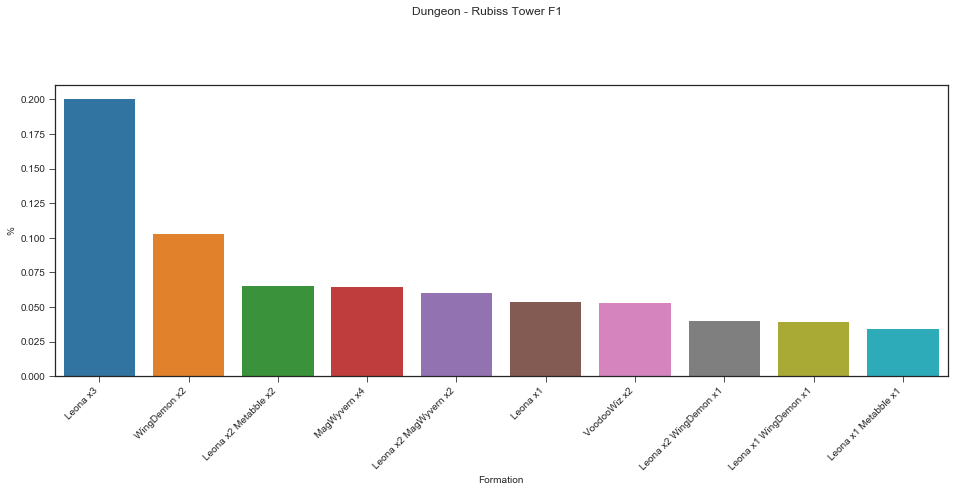

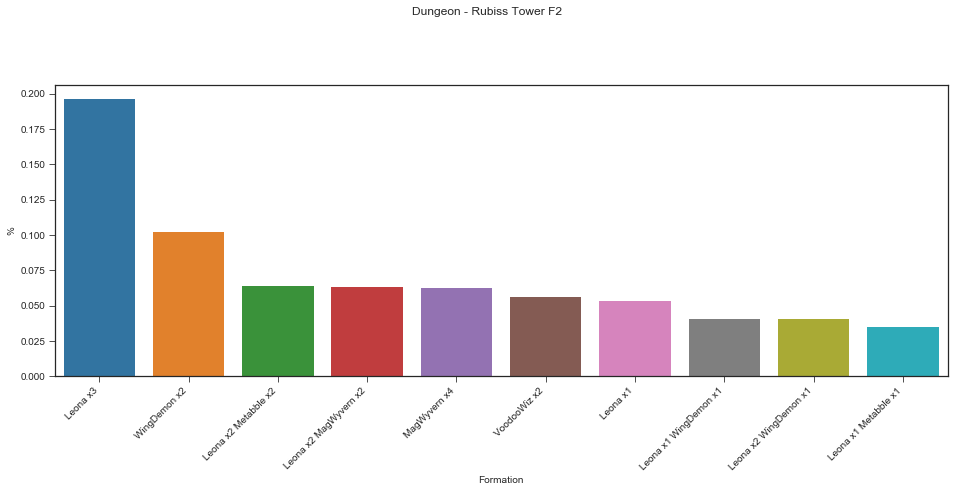

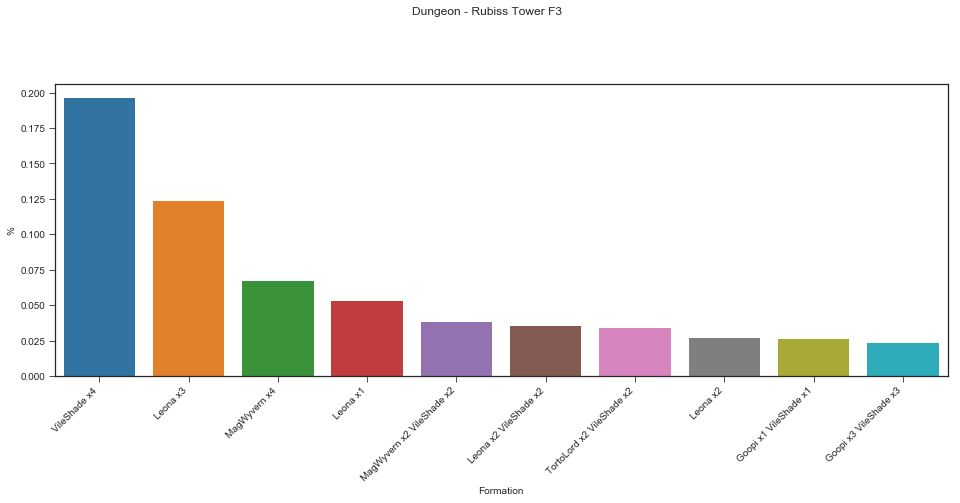

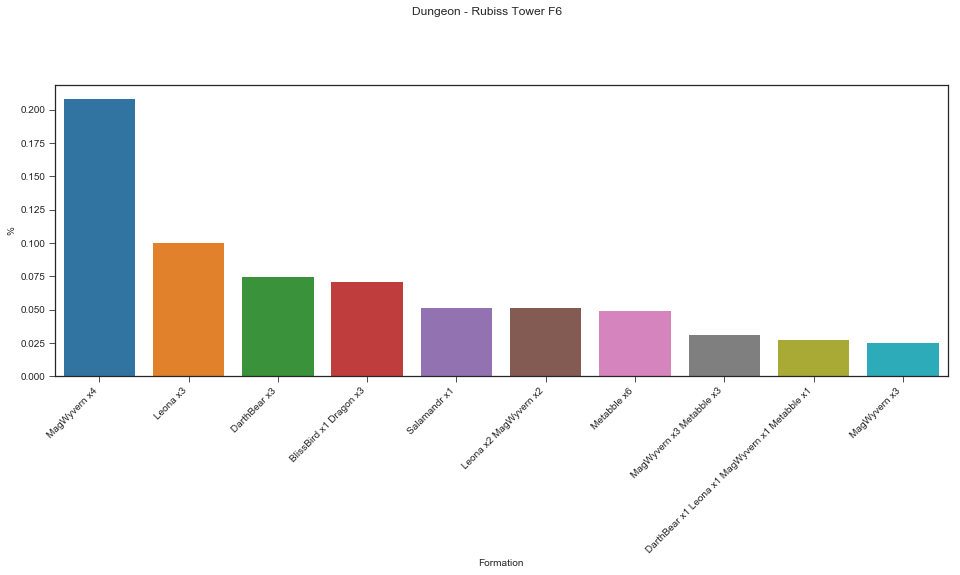

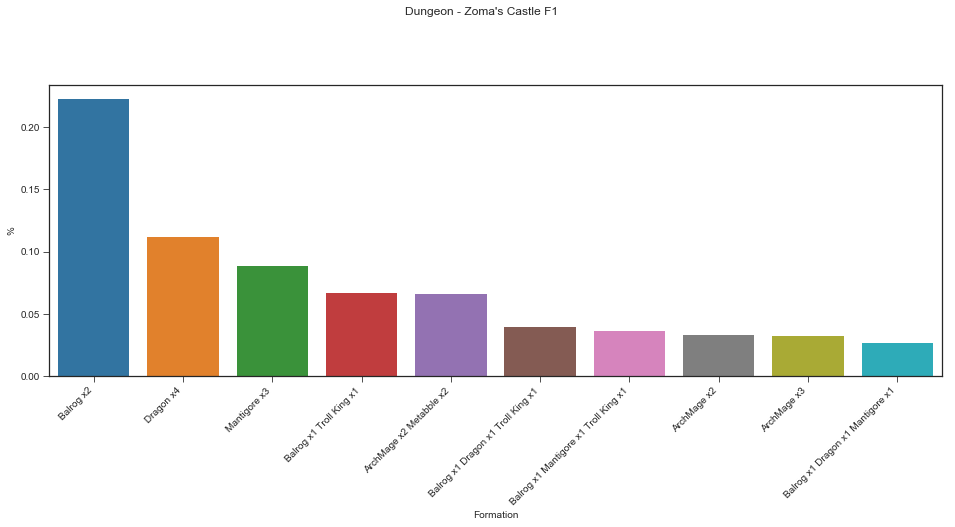

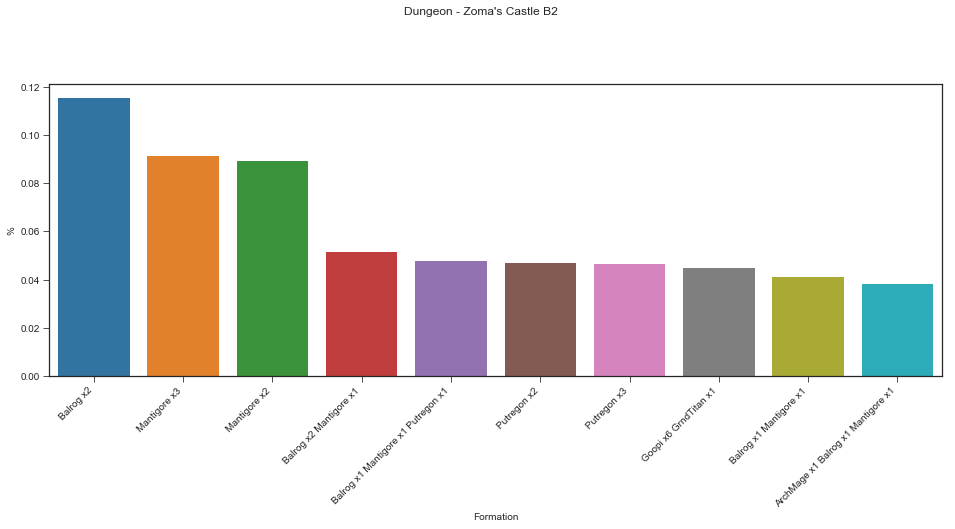

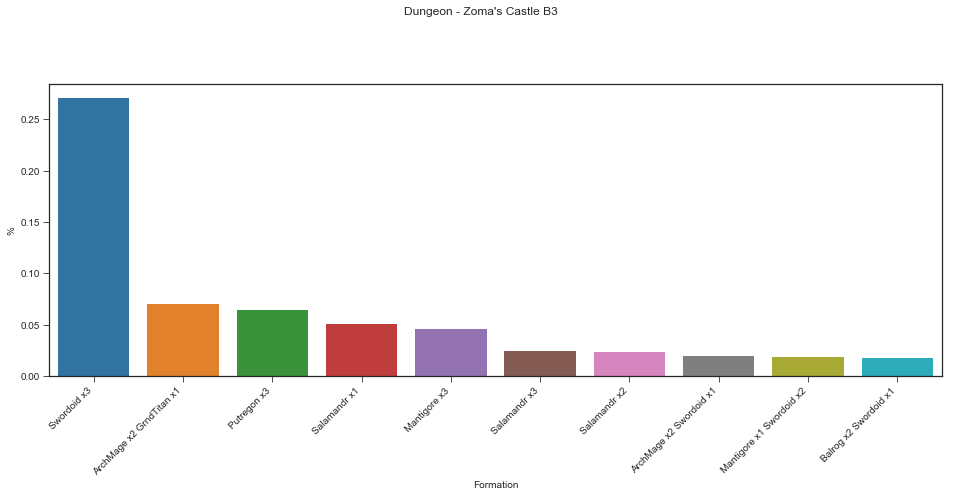

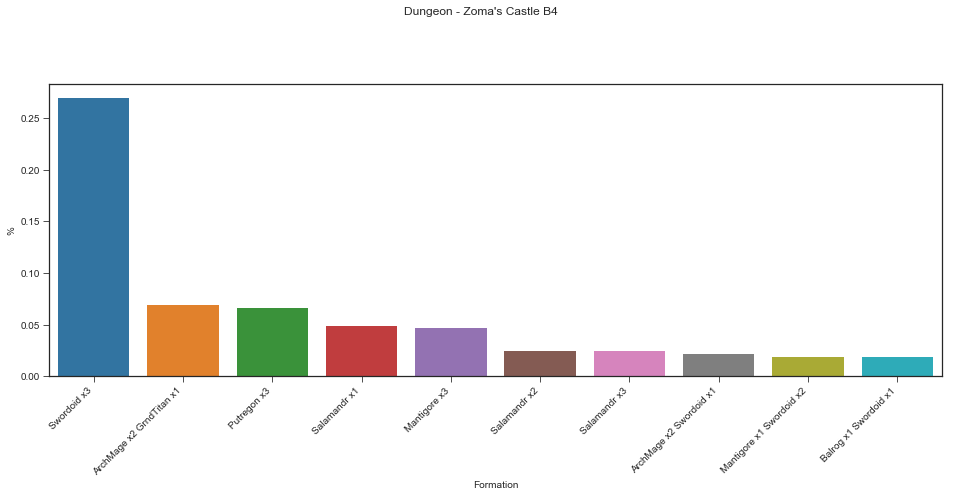

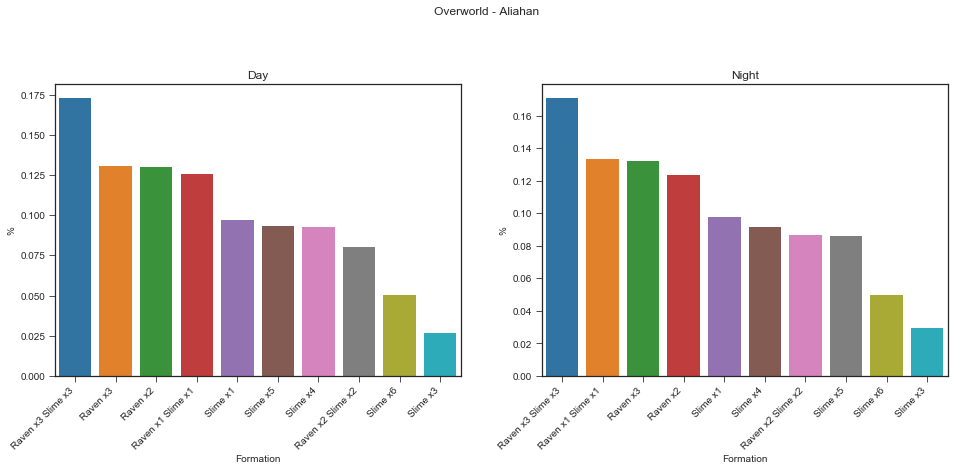

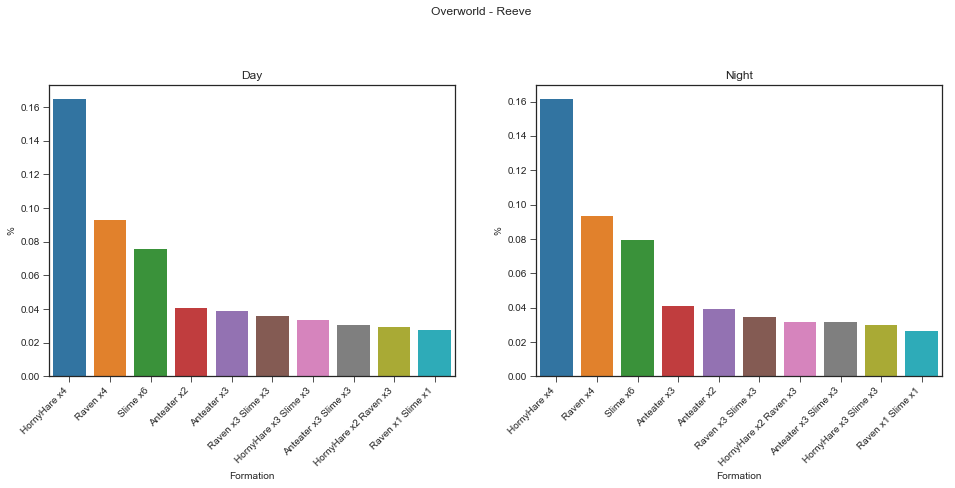

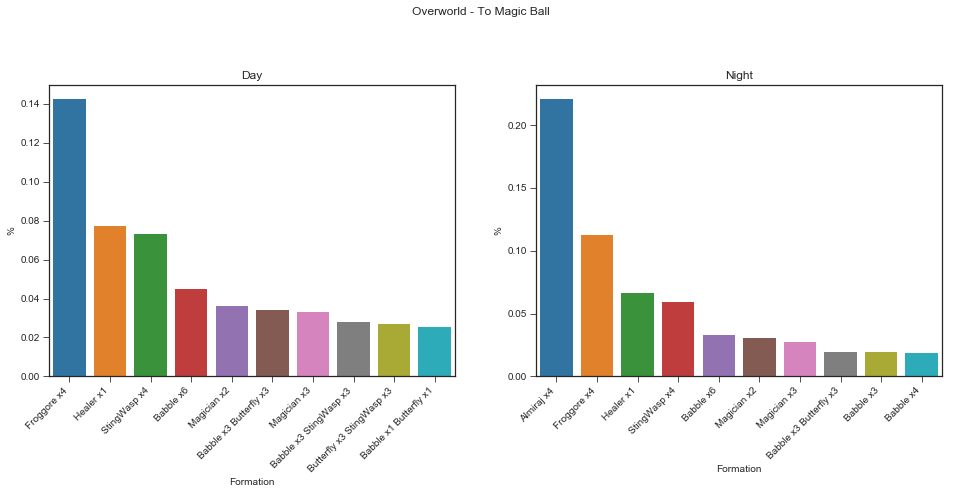

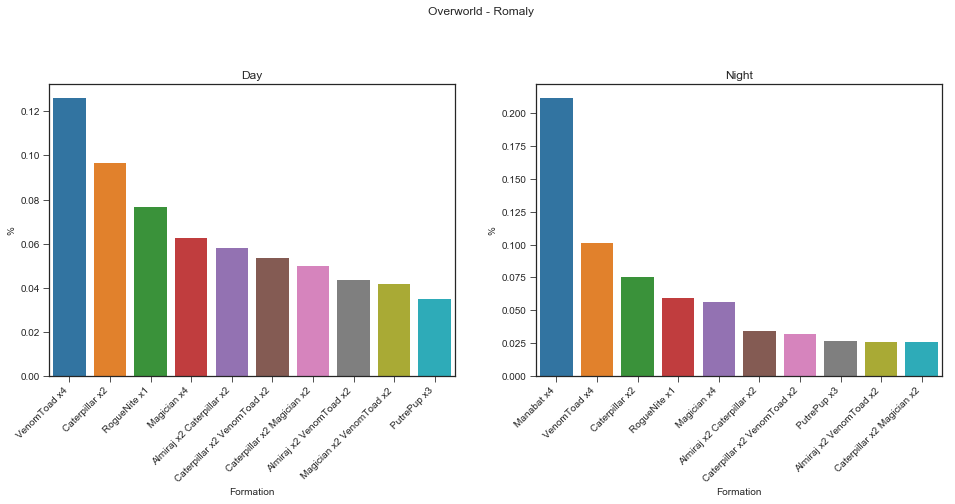

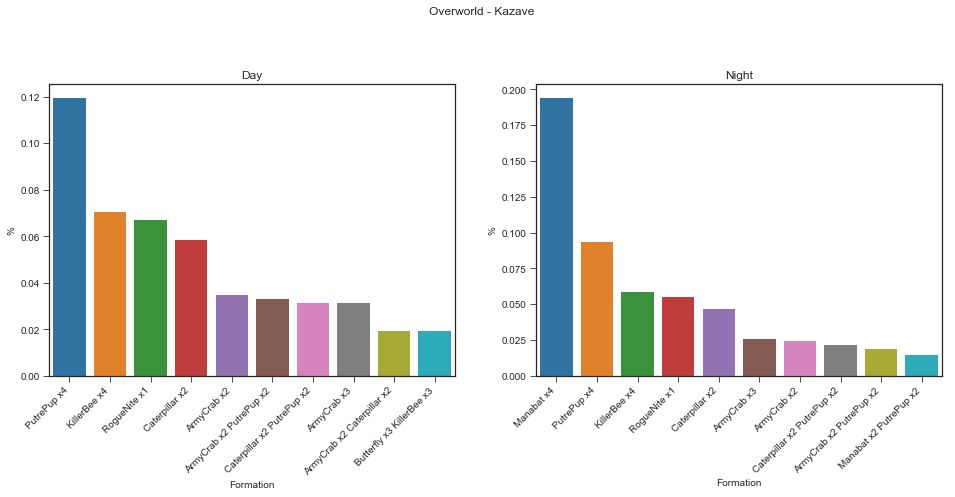

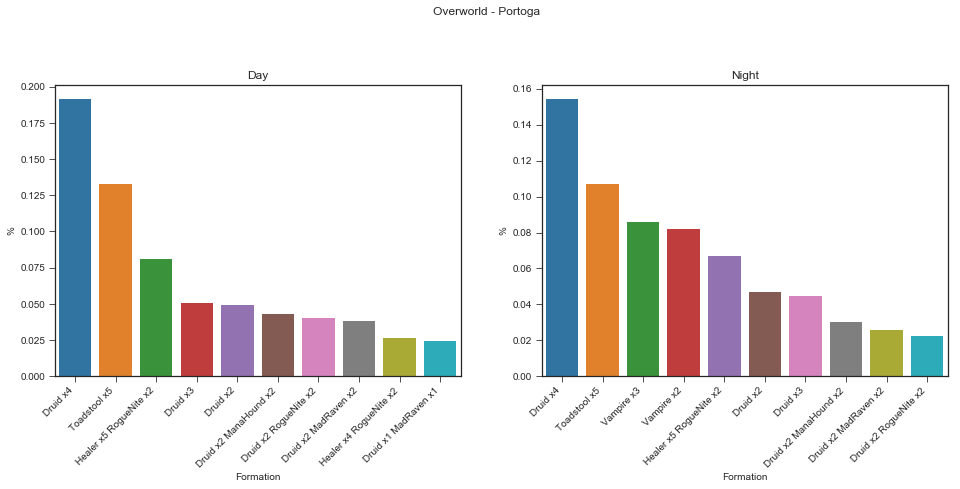

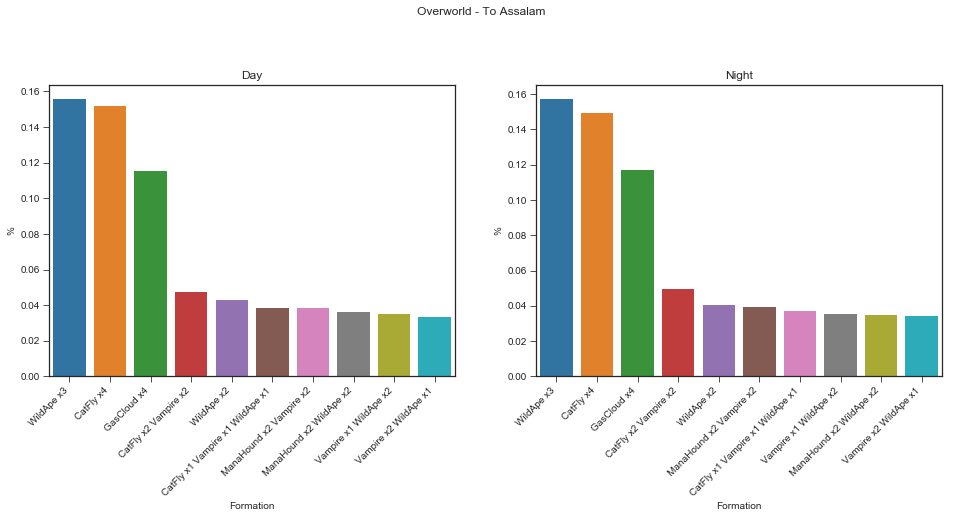

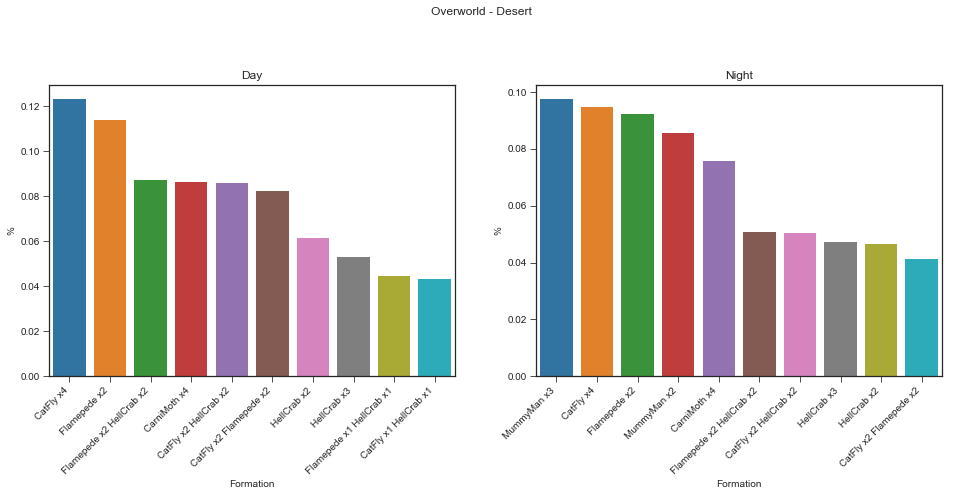

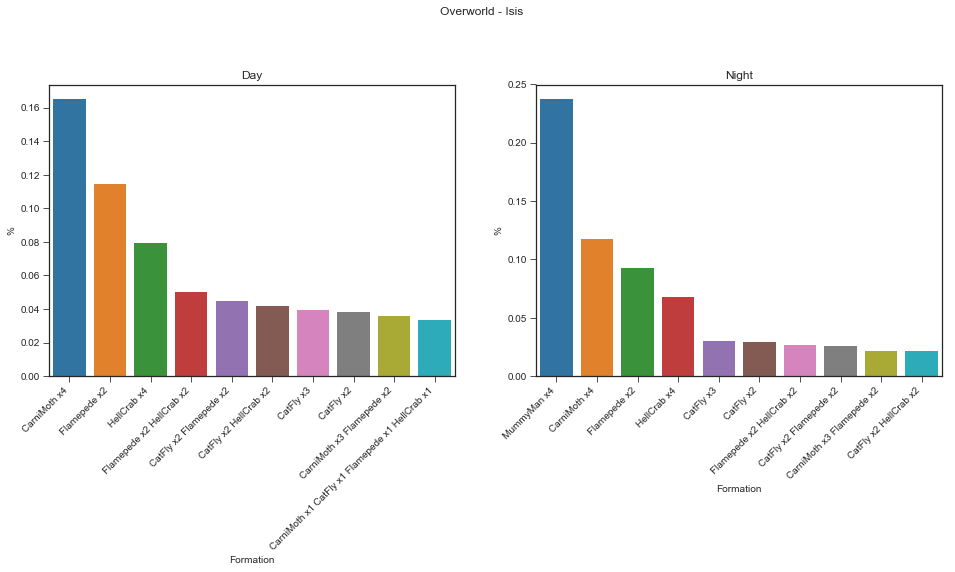

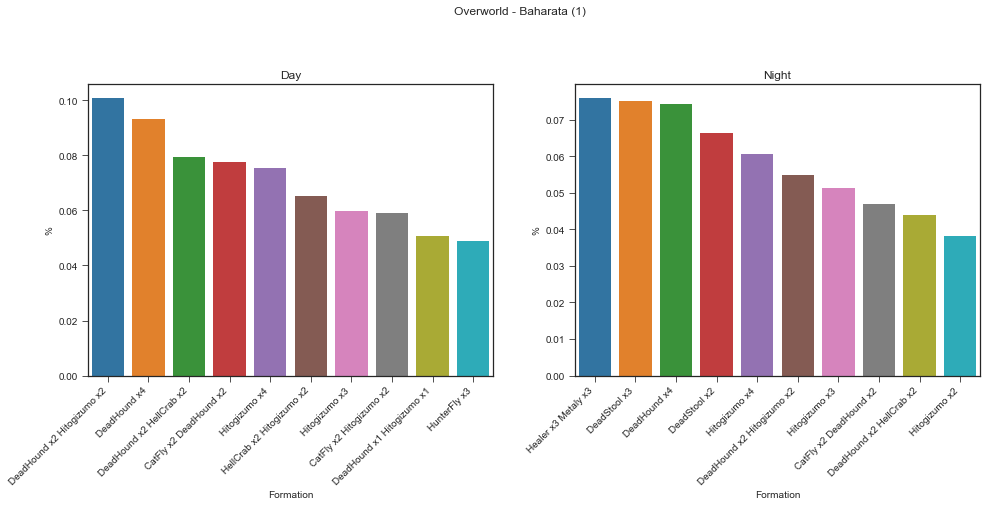

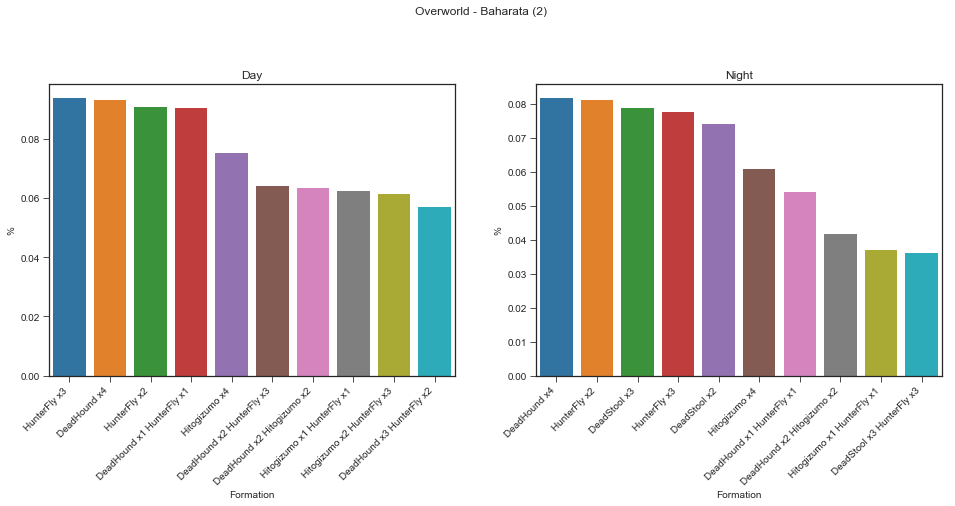

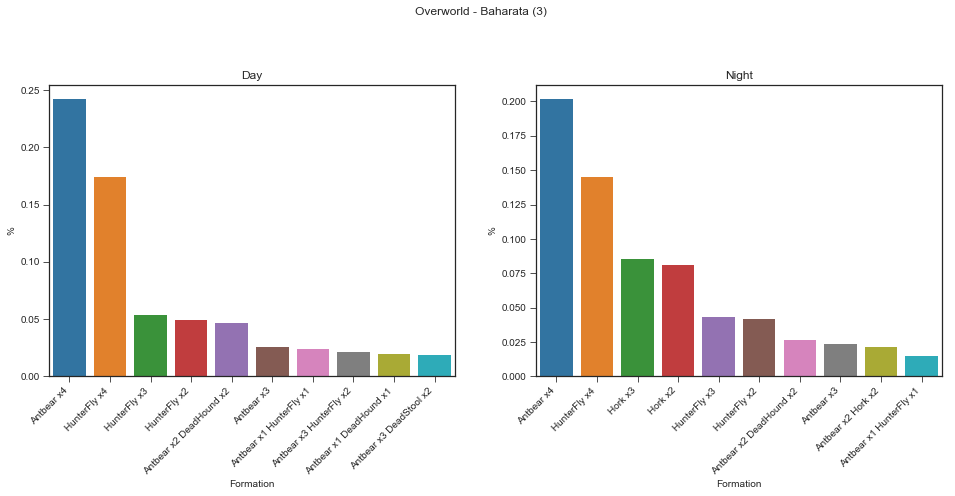

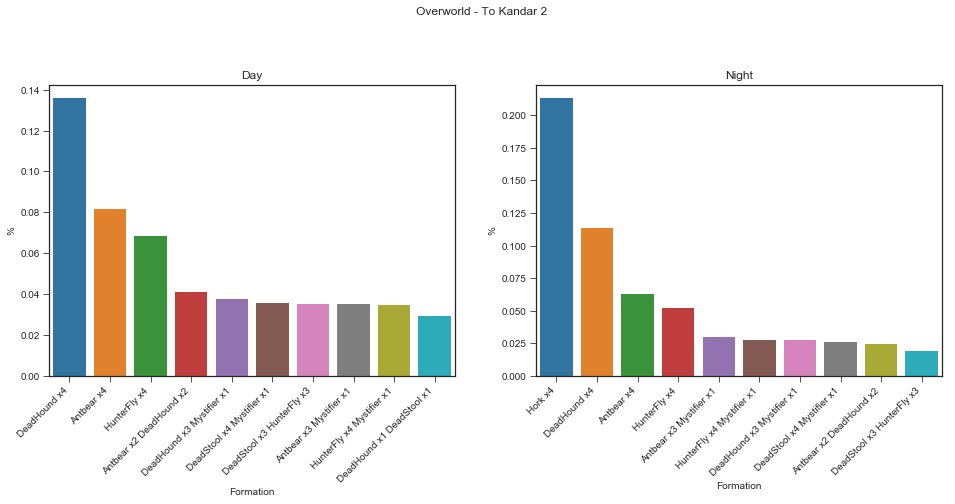

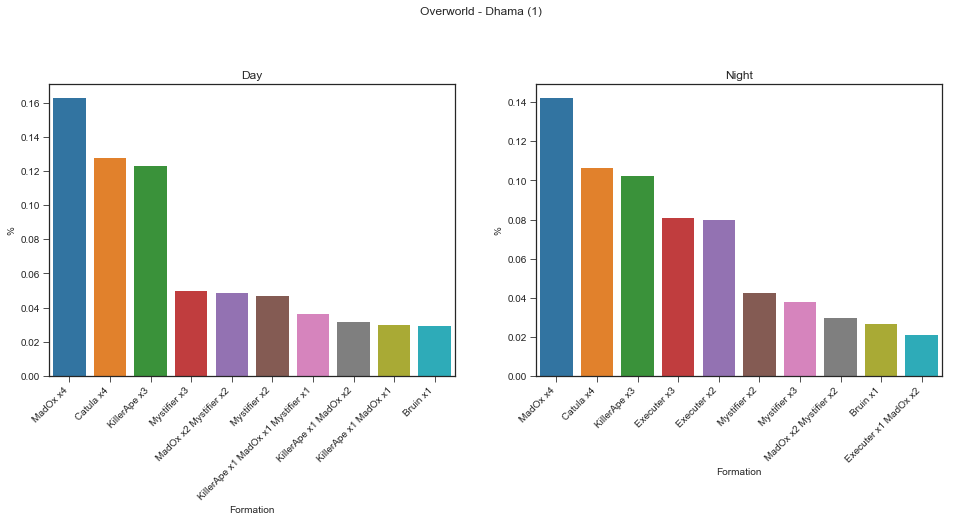

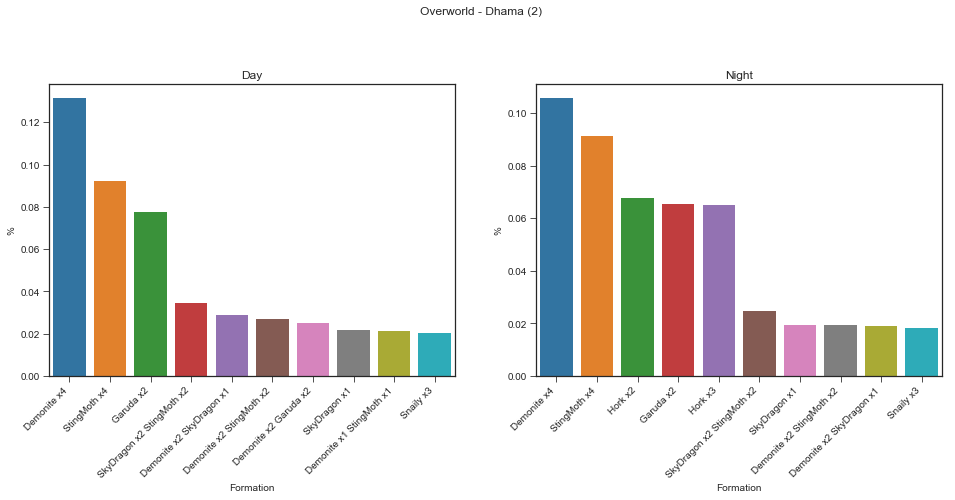

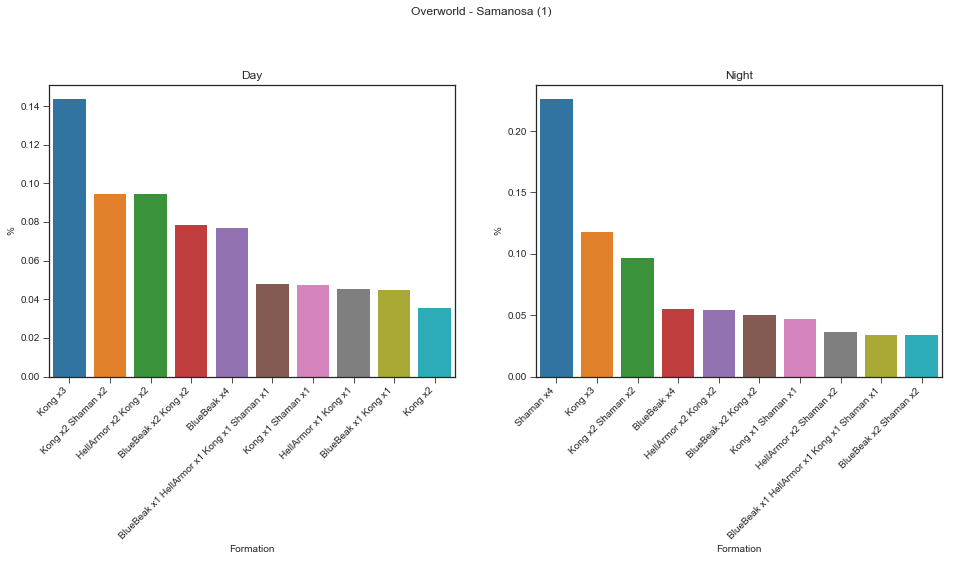

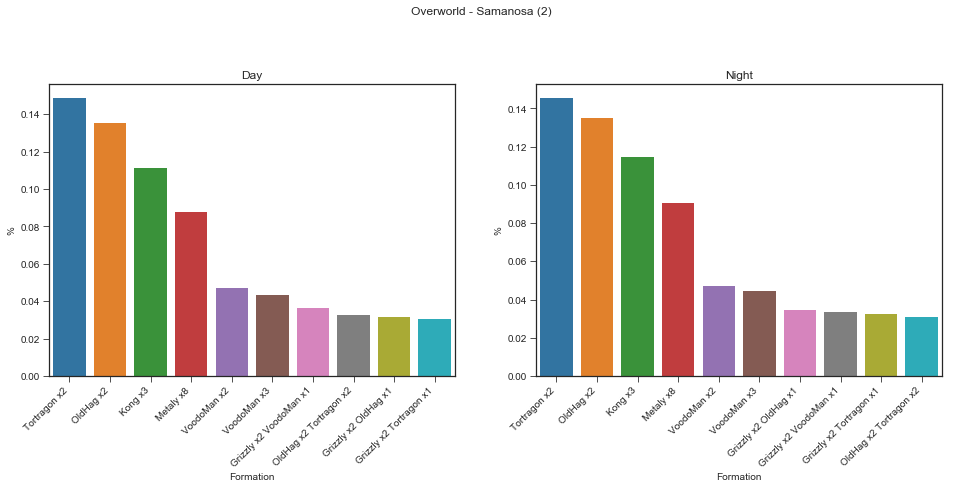

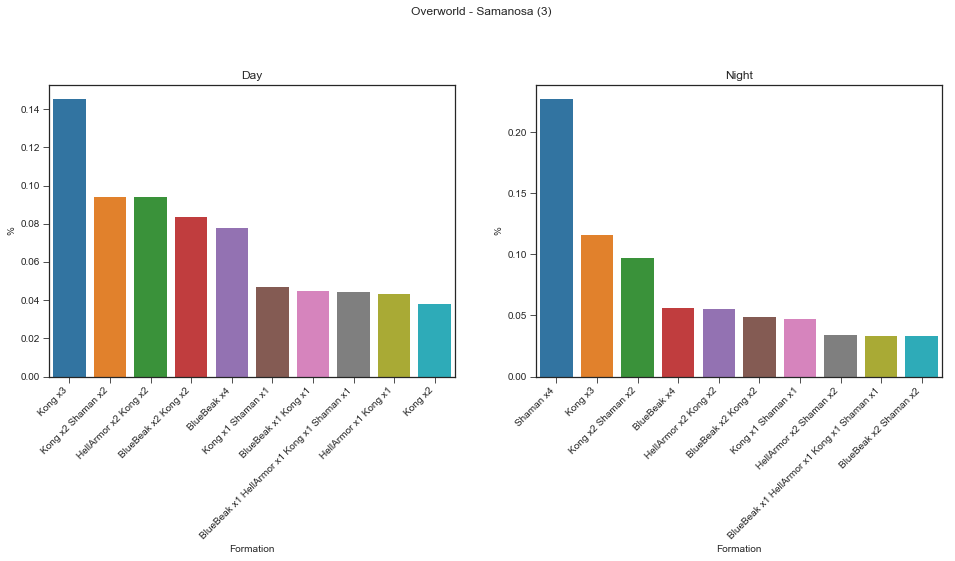

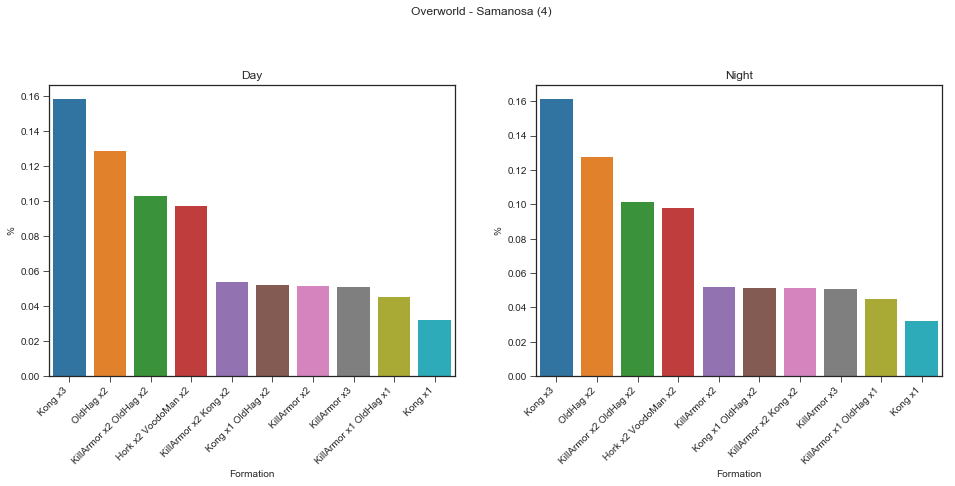

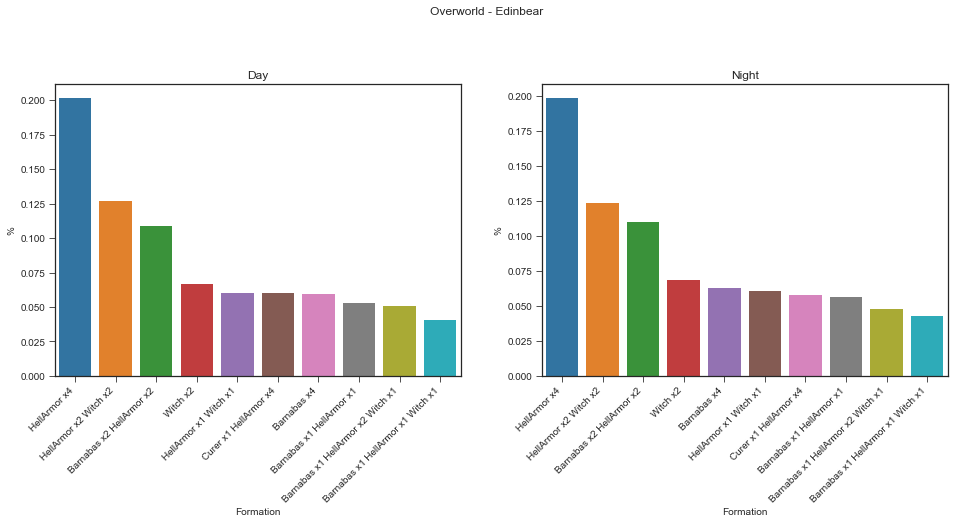

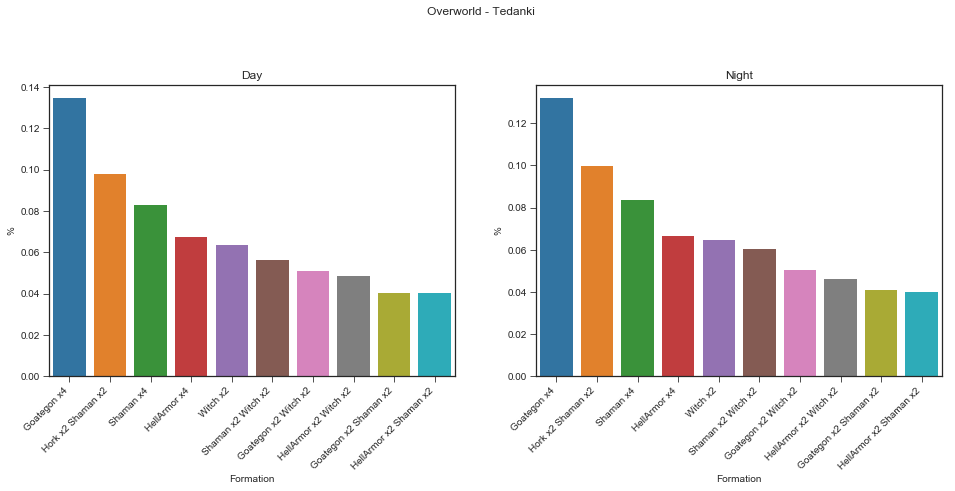

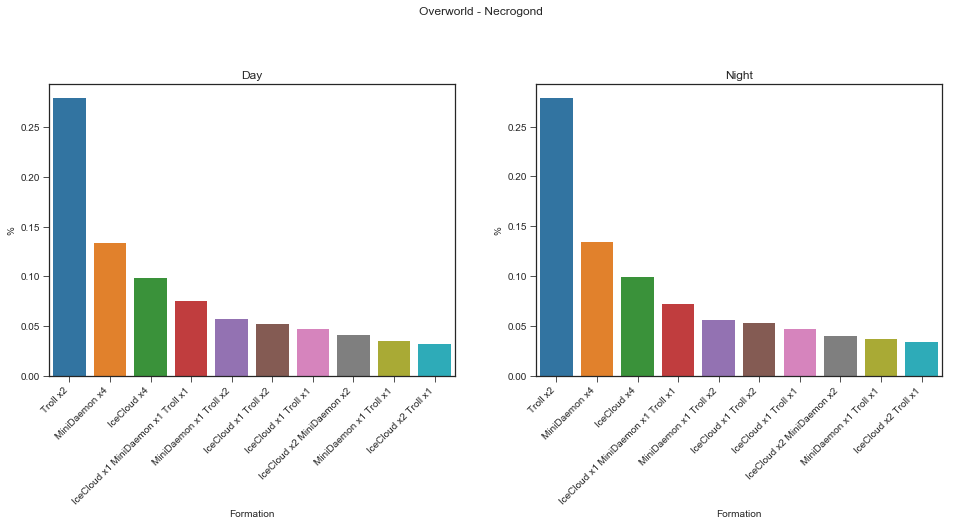

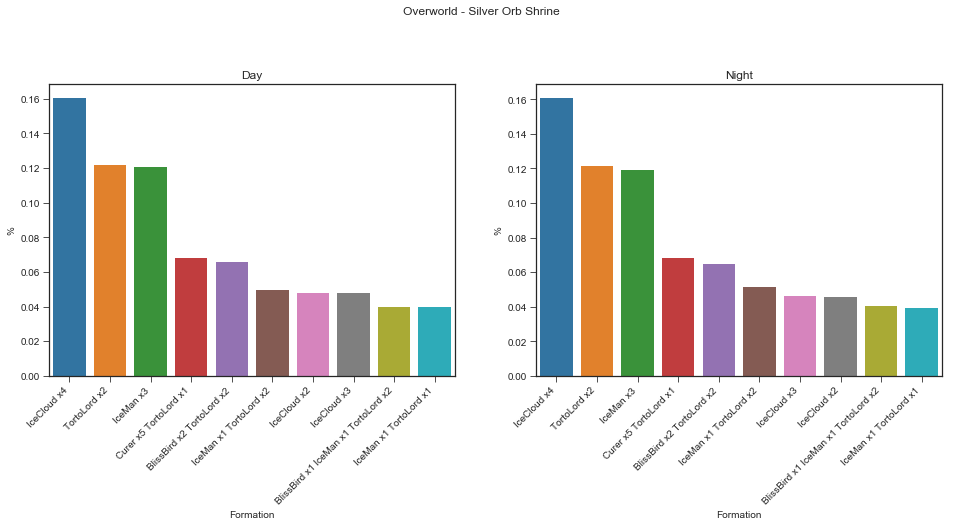

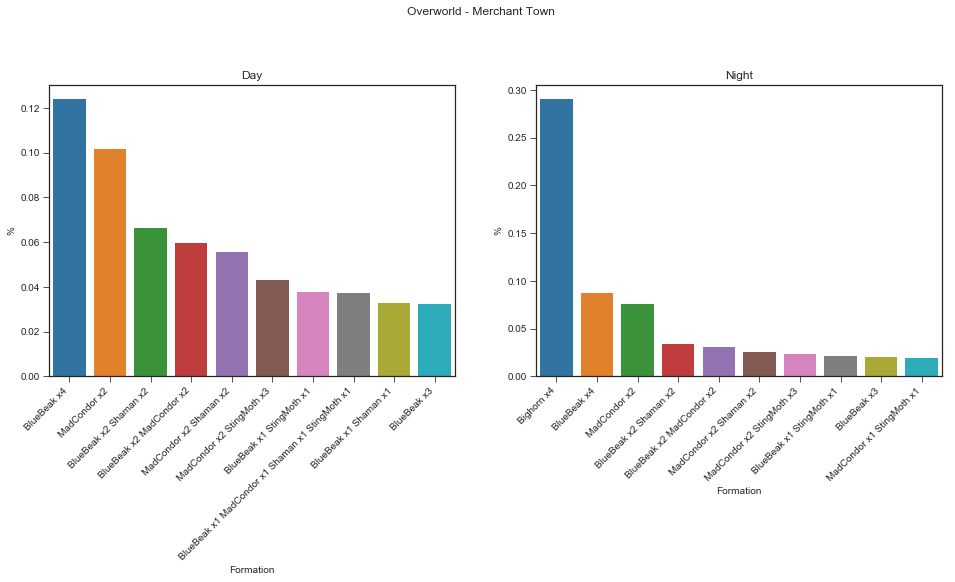

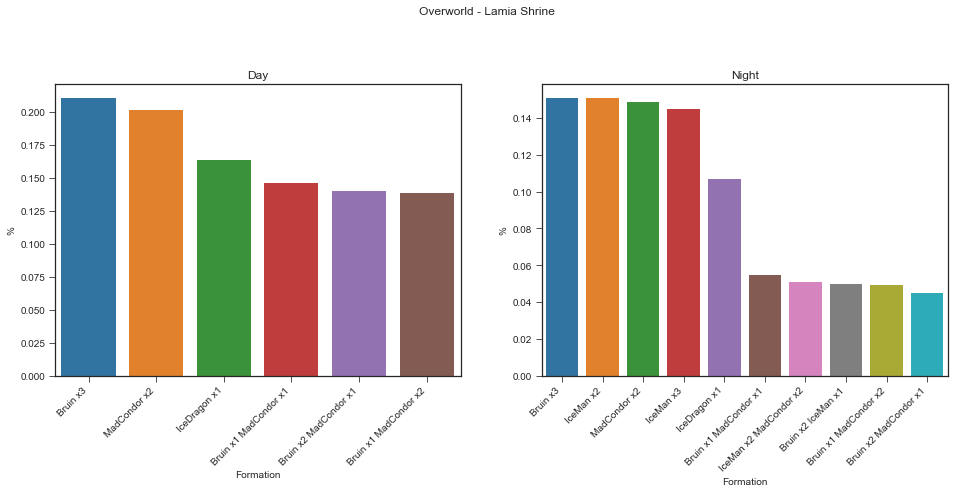

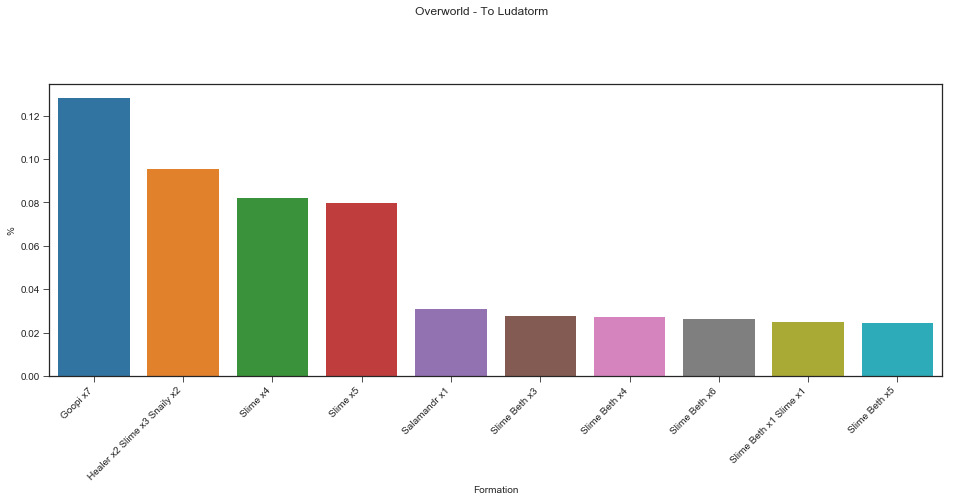

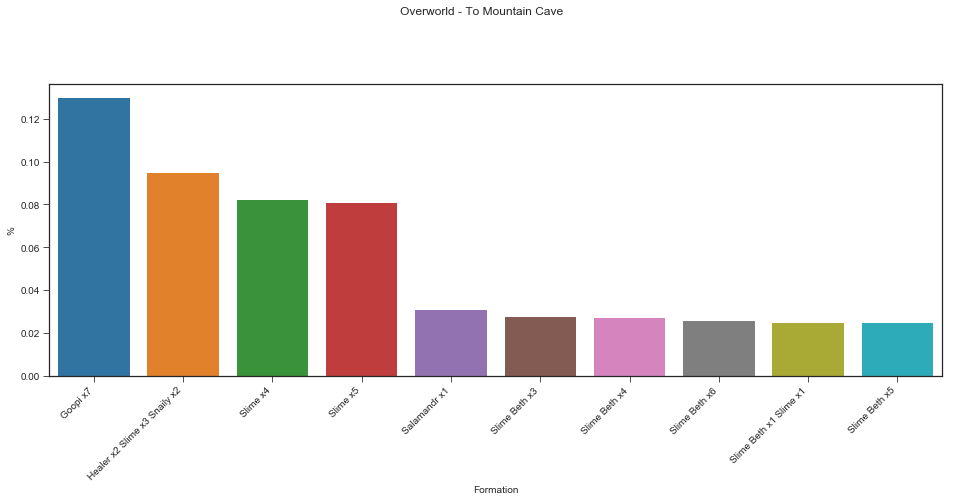

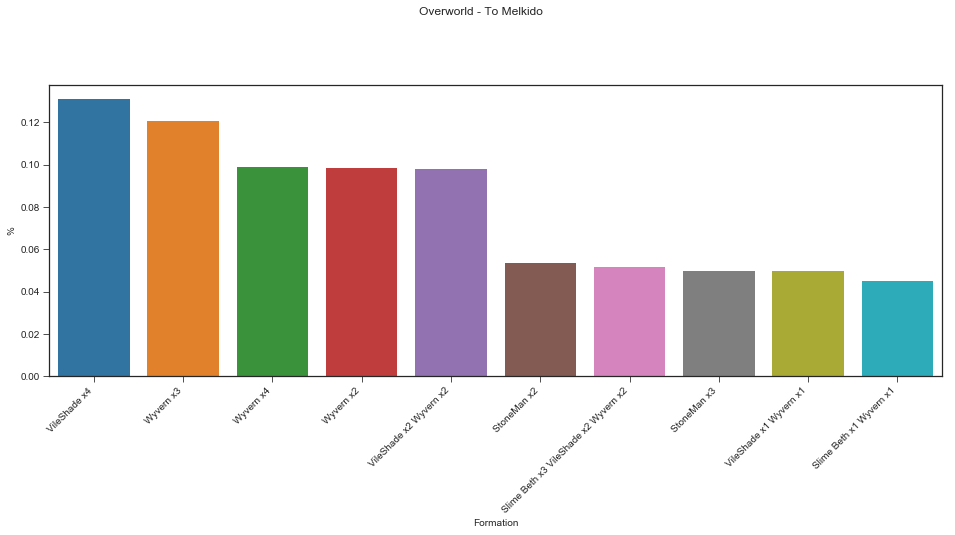

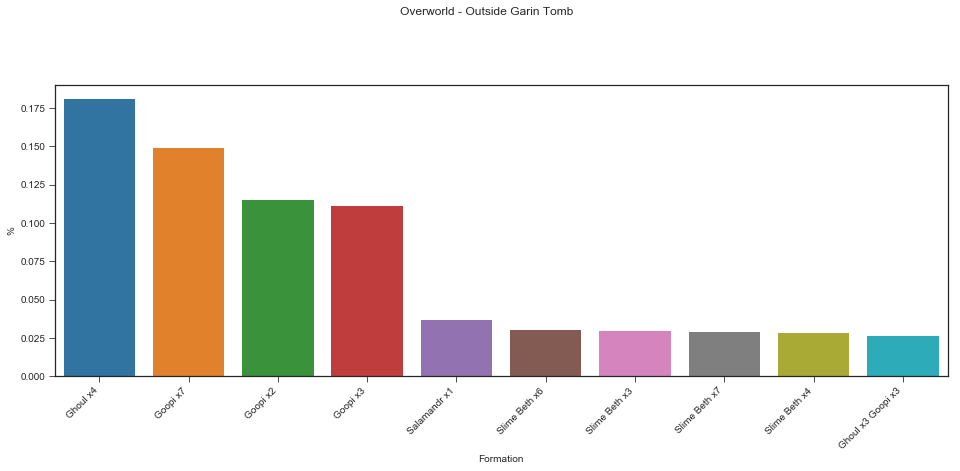

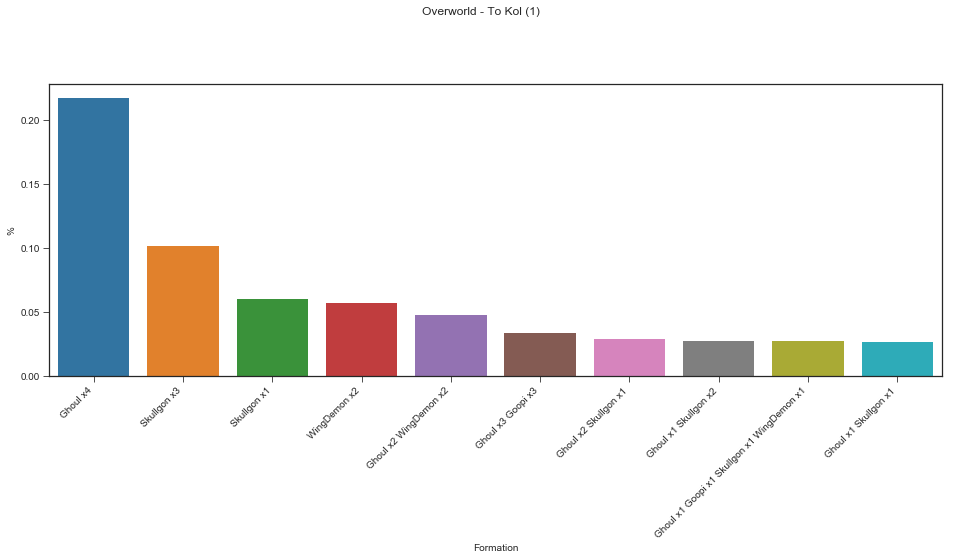

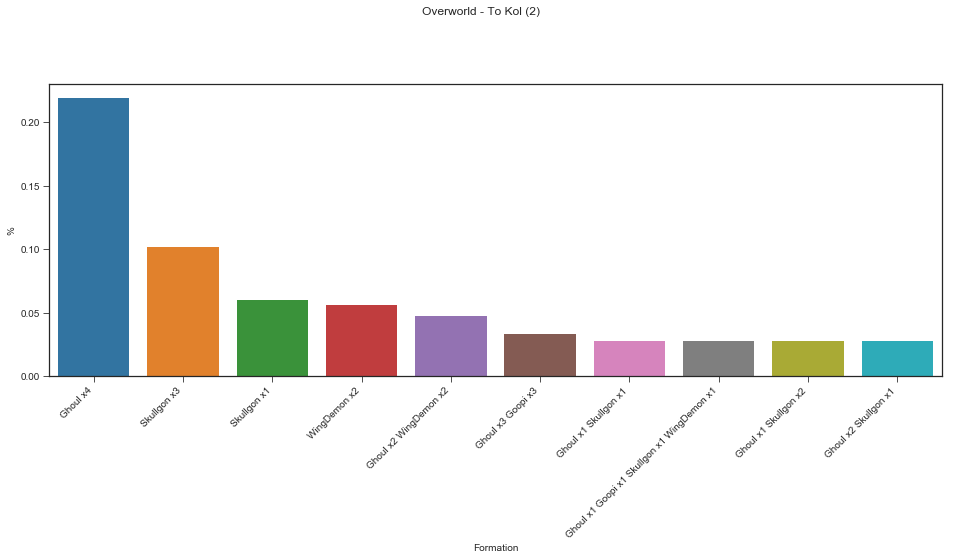

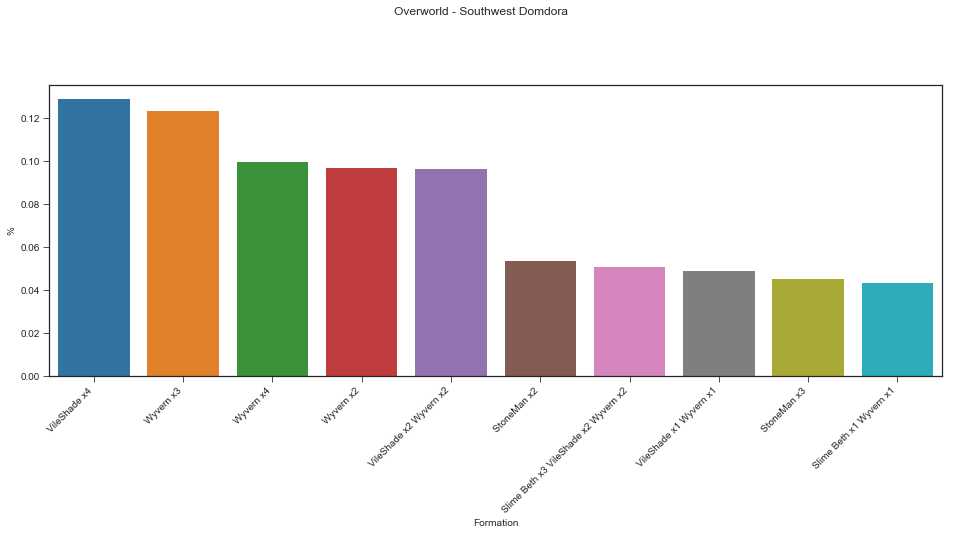

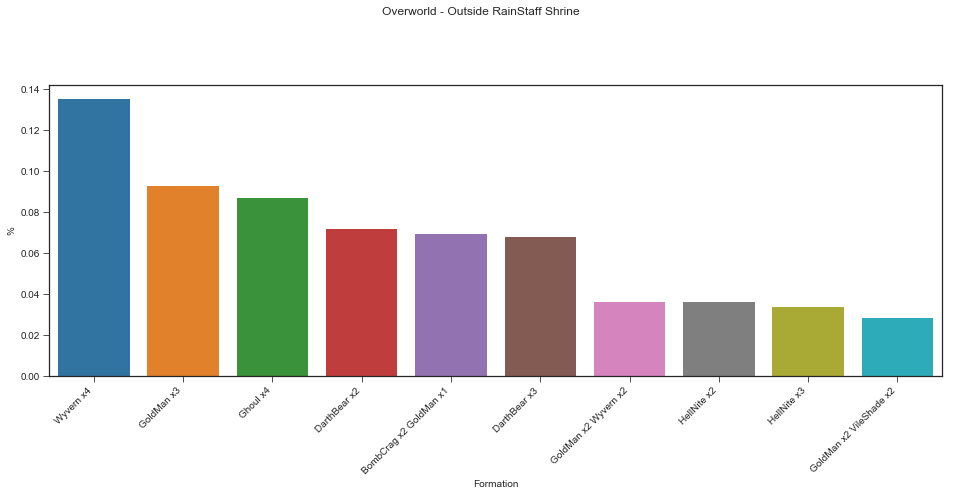

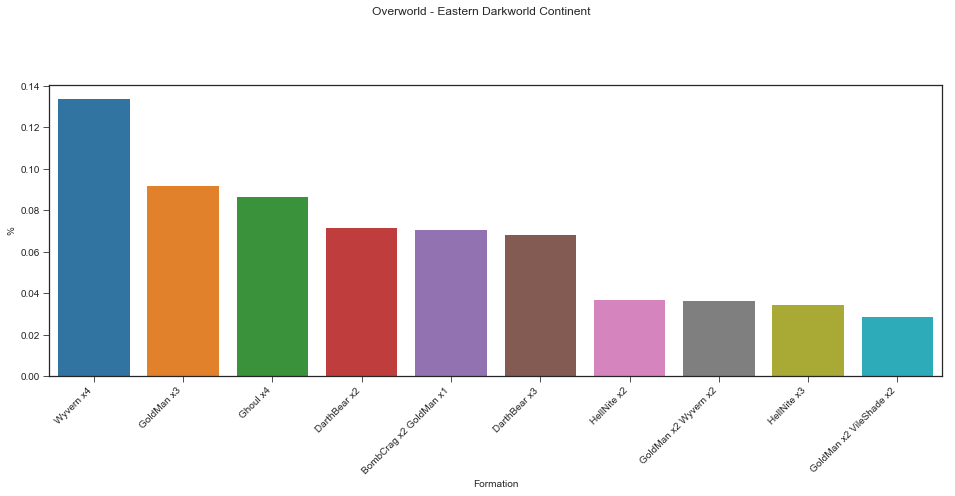

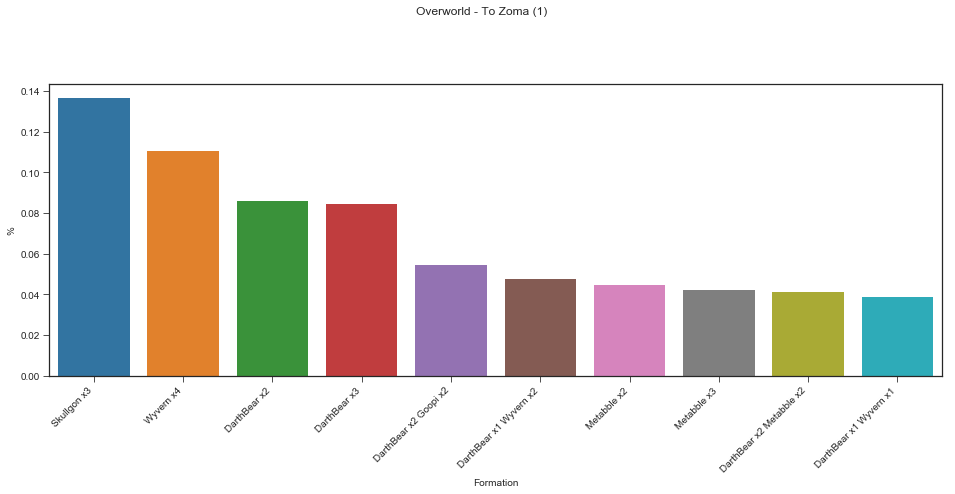

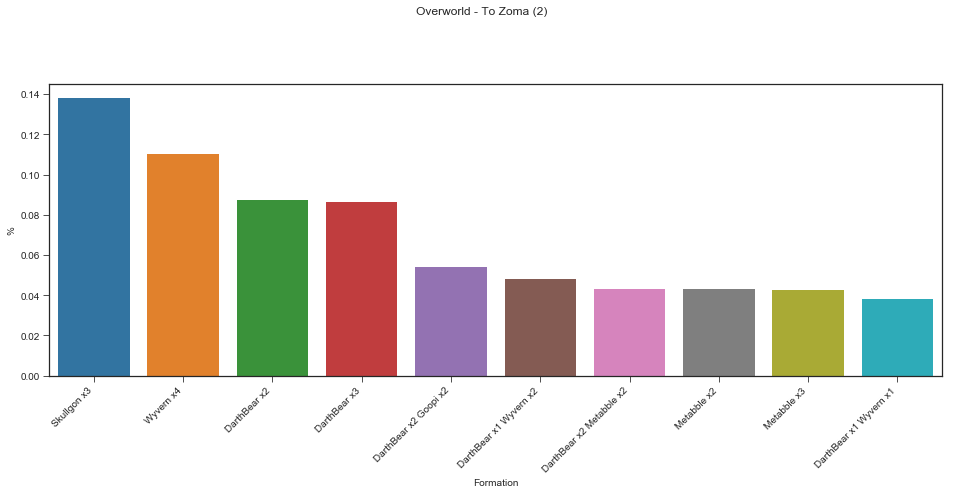

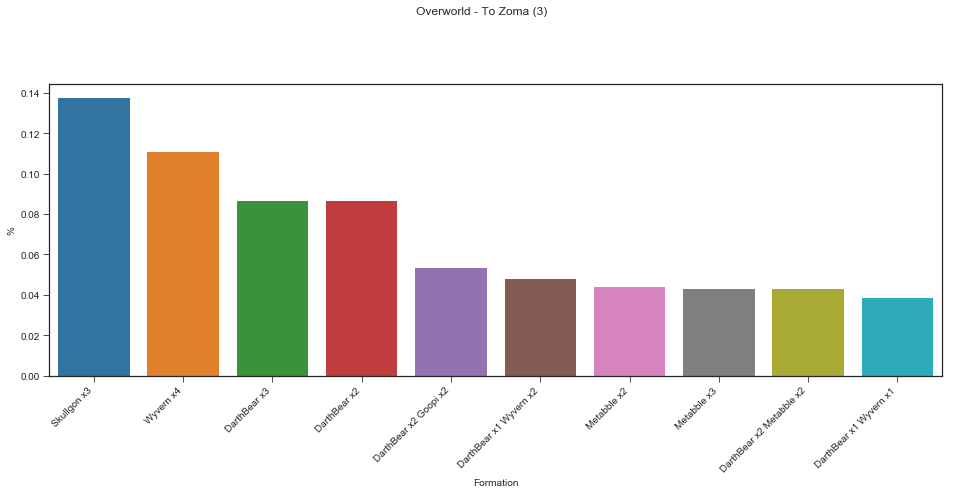

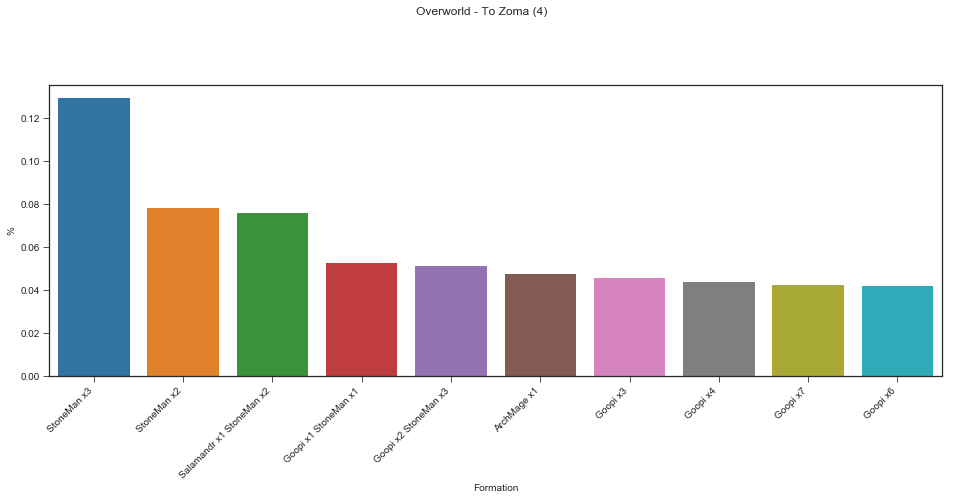

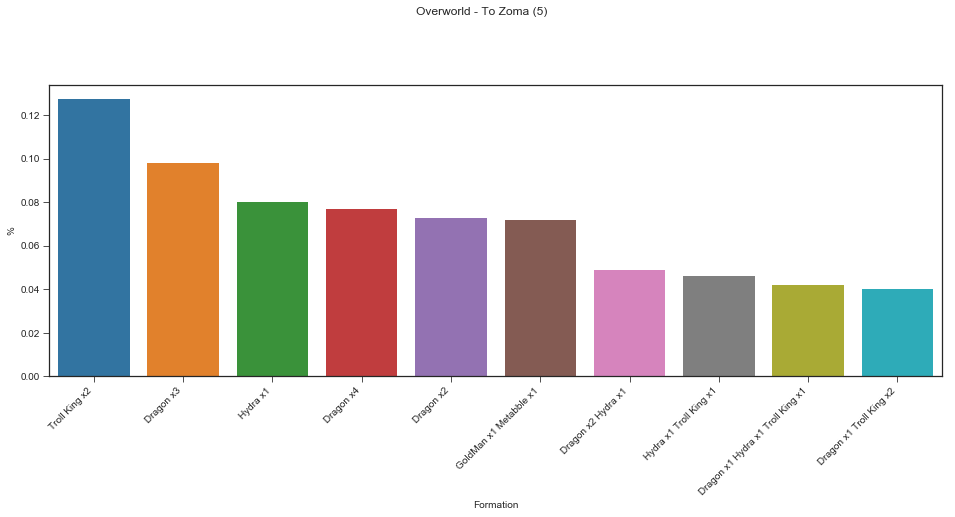

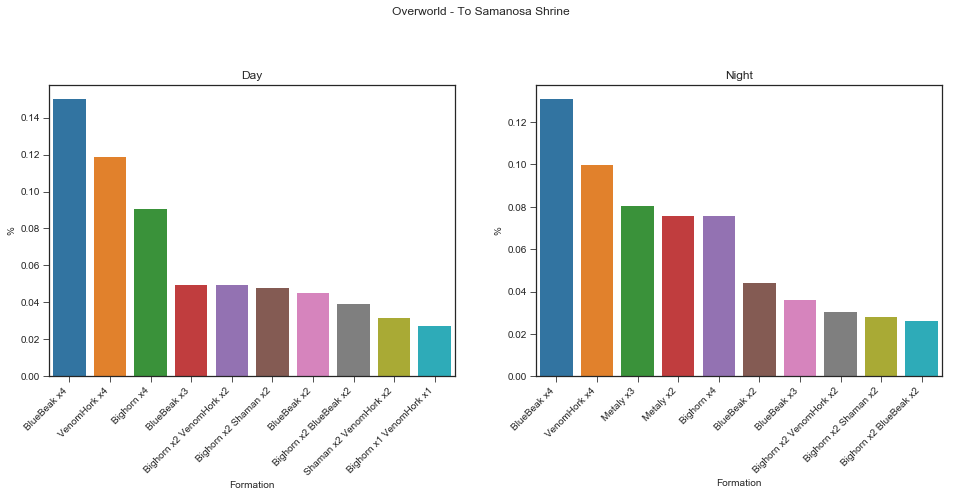

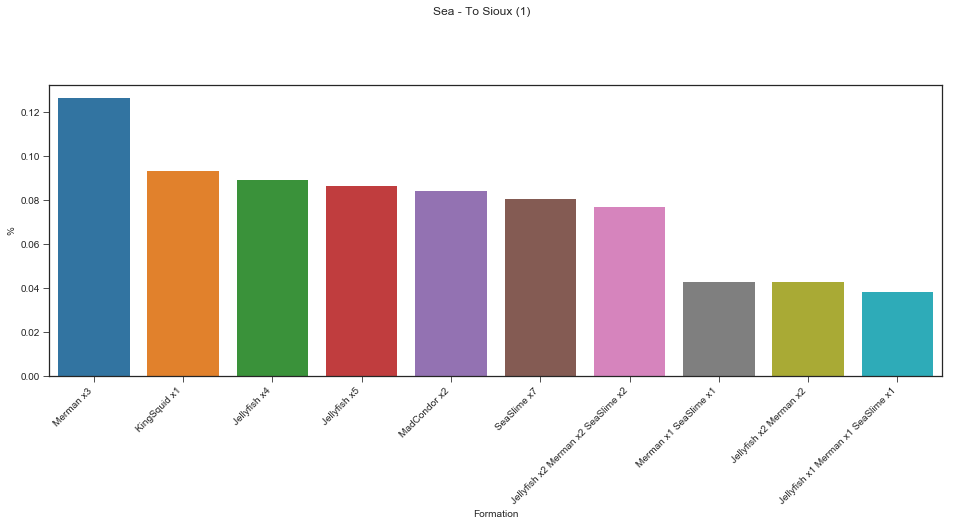

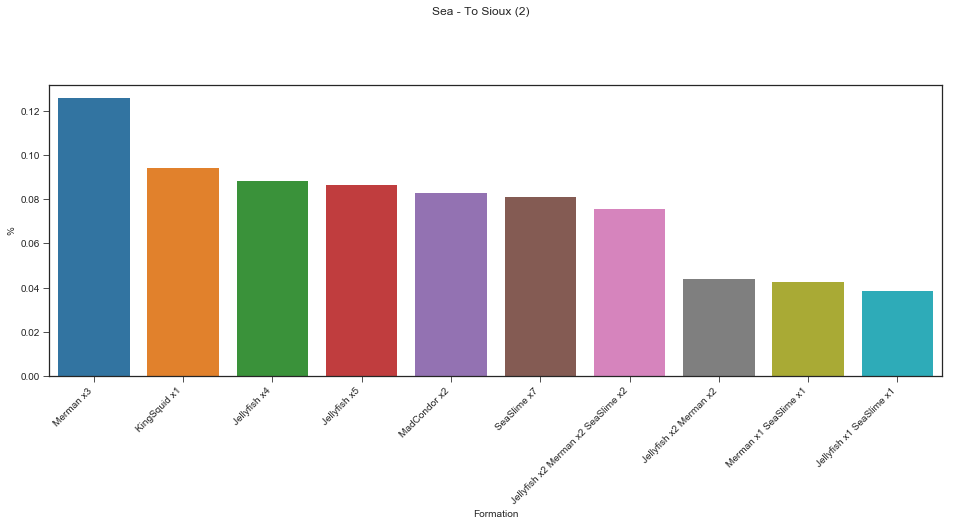

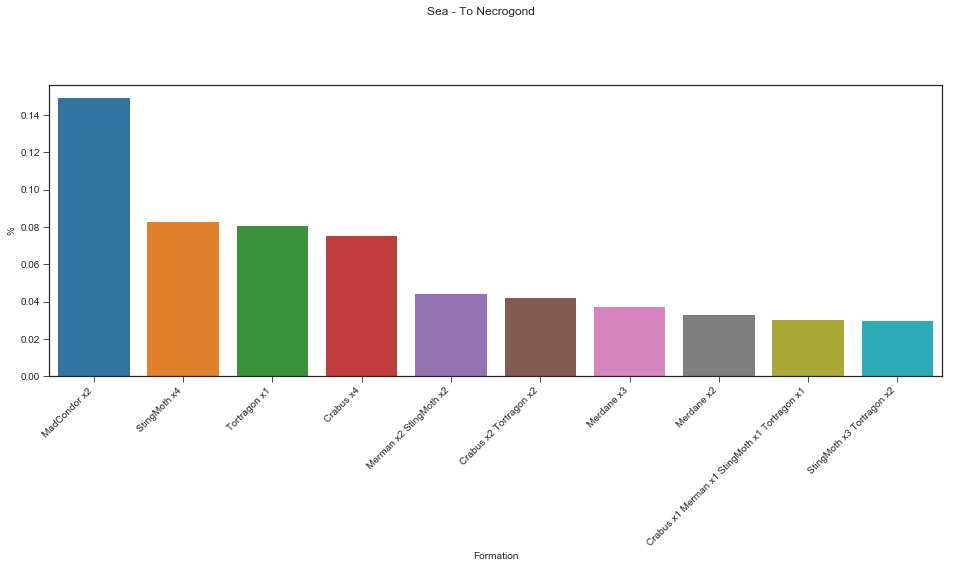

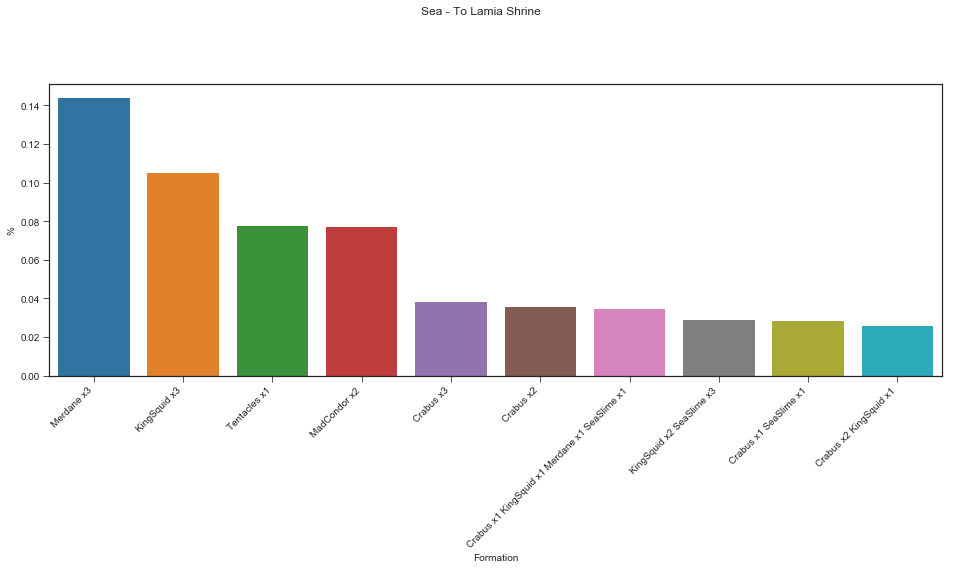

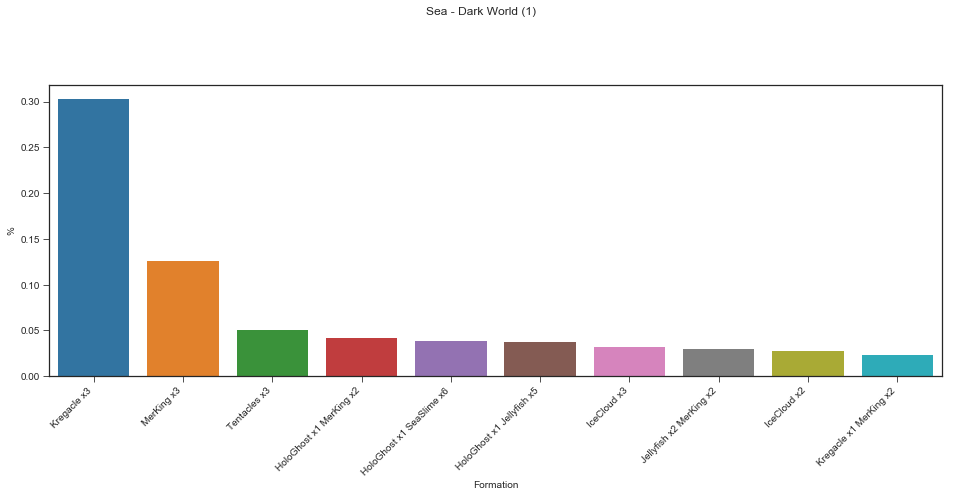

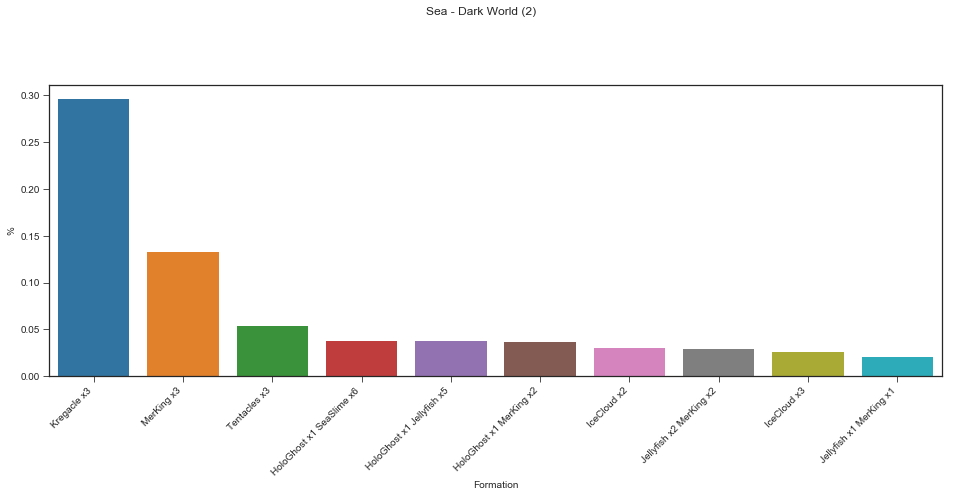

In [121]:
for maptype in maptypes_list:
    df1 = df.loc[(df['Map Type'] == maptype)]

    zones_list = df1['Zone'].unique().tolist()
    areacode_list = df1['Area Code'].unique().tolist()
    zonedict = dict(zip(areacode_list,zones_list))
    for areacode in sorted(areacode_list):
        zone = zonedict[areacode]
        df2 = df1.loc[(df1['Map Type'] == maptype) & (df1['Zone'] == zone)]
        try:
            if zone in daynightlist:
                df_day, df_night = return_daynight(df2,maptype,zone)
                plot_two(df_day,df_night,maptype,zone)
            else:
                df_query = return_df(df2, maptype,zone)
                plot_one(df_query, maptype, zone)
        except:
            print("Error on "+maptype+" : "+zone+"!")